# Homework 11 - Transfer Learning (Domain Adversarial Training)

> Author: Howard Wang (b08902047@ntu.edu.tw)

If there are any questions, please contact mlta-2023-spring@googlegroups.com

# Readme

In homework 11, you will need to implement Domain Adversarial Training in Transfer Learning. As shown in the bottom left part of the figure.

<img src="https://i.imgur.com/iMVIxCH.png" width="500px">

> 

## Scenario and Why Domain Adversarial Training
Now we have labeled source data and unlabeled target data, where source data might be relavent to the target data. We now want to train a model with source data only and test it on target data.

What problem might occur if we do so? After we have learned Anomaly Detection, we now know that if we test the model with an abnormal data that have never appeared in source data, our trained model is likely to result in poor performance since it is not familiar with the abnormal data.

For example, we have a model that contains Feature Extractor and Classifier:
<img src="https://i.imgur.com/IL0PxCY.png" width="500px">

When the model is trained with source data, the feature extractor 
will extract meaningful features since it is familiar with the distribution of it.It could be seen in the following figure that the blue dots, which is the distribution of source data, has already been clustered into different clusters. Therefore, the Classifier can predict the label based on these clusters.

However, when test on the target data, the Feature Extractor will not be able to extract meaningful features that follow the distribution of the source feature distribution, which result in the classifier learned for the source domain will not be able to apply to the target domain.


## Domain Adversarial Training of Nerural Networks (DaNN)

Based on the above problems, DaNN approaches build mappings between the source (training-time) and the target (test-time) domains, so that the classifier learned for the source domain can also be applied to the target domain, when composed with the learned mapping between domains.

<img src="https://i.imgur.com/vrOE5a6.png" width="500px">

In DaNN, the authors added a Domain Classifier, which is a deep discriminatively-trained classifeir in the training framework to distinguish the data from different domain by the features extracted by the feature extractor. As the training progresses, the approach promotes a domain classifier that discriminates between the source and the target domains and a feature extractor that can extractor features that are discriminative for the main learning task on the source domain and indiscriminate with respect to the shift between the domains. 


The feature extractor are likely to outperform the domain classifier as its input are generated by the feature extractor and that the task of domain classification and label classification are not conflict.

This method leads to the emergence of features that are domain-invariant and on the same feature distribution.

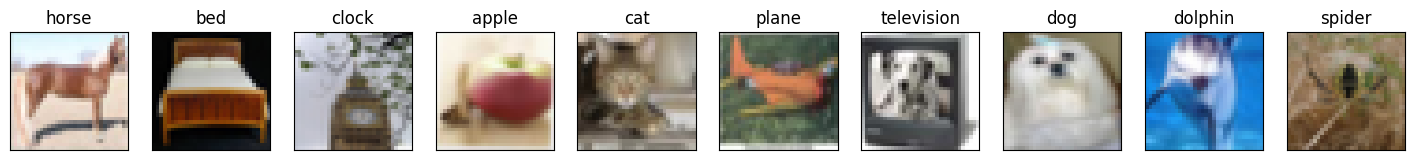

In [3]:
import matplotlib.pyplot as plt

def no_axis_show(img, title='', cmap=None):
  # imshow, and set the interpolation mode to be "nearest"。
  fig = plt.imshow(img, interpolation='nearest', cmap=cmap)
  # do not show the axes in the images.
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.title(title)

titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/train_data/{i}/{500*i}.bmp'), title=titles[i])

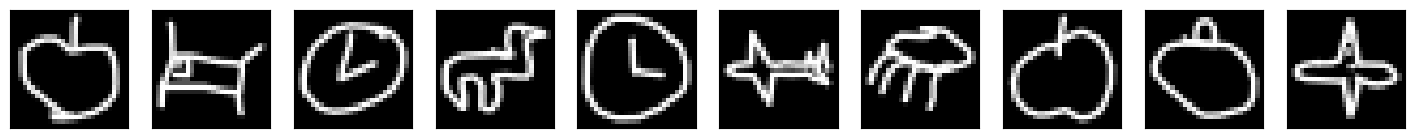

In [4]:
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/test_data/0/' + str(i).rjust(5, '0') + '.bmp'))

# Special Domain Knowledge

When we graffiti, we usually draw the outline only, therefore we can perform edge detection processing on the source data to make it more similar to the target data.


## Canny Edge Detection
The implementation of Canny Edge Detection is as follow.
The algorithm will not be describe thoroughly here.  If you are interested, please refer to the wiki or [here](https://medium.com/@pomelyu5199/canny-edge-detector-%E5%AF%A6%E4%BD%9C-opencv-f7d1a0a57d19).

We only need two parameters to implement Canny Edge Detection with CV2:  `low_threshold` and `high_threshold`.

```cv2.Canny(image, low_threshold, high_threshold)```

Simply put, when the edge value exceeds the high_threshold, we determine it as an edge. If the edge value is only above low_threshold, we will then determine whether it is an edge or not.

Let's implement it on the source data.

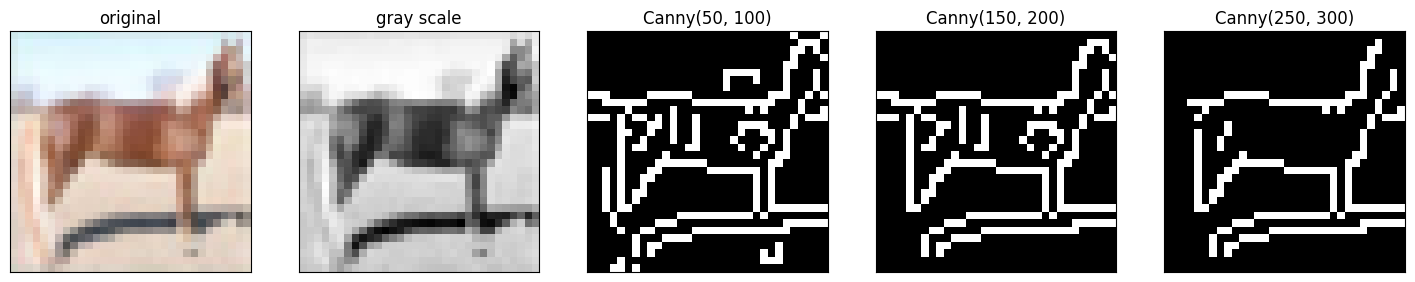

In [5]:
import cv2
import matplotlib.pyplot as plt
titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))

original_img = plt.imread(f'real_or_drawing/train_data/0/0.bmp')
plt.subplot(1, 5, 1)
no_axis_show(original_img, title='original')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

canny_50100 = cv2.Canny(gray_img, 50, 100)
plt.subplot(1, 5, 3)
no_axis_show(canny_50100, title='Canny(50, 100)', cmap='gray')

canny_150200 = cv2.Canny(gray_img, 150, 200)
plt.subplot(1, 5, 4)
no_axis_show(canny_150200, title='Canny(150, 200)', cmap='gray')

canny_250300 = cv2.Canny(gray_img, 250, 300)
plt.subplot(1, 5, 5)
no_axis_show(canny_250300, title='Canny(250, 300)', cmap='gray')

# Data Process
 
 
The data is suitible for `torchvision.ImageFolder`. You can create a dataset with `torchvision.ImageFolder`. Details for image augmentation please refer to the comments in the following codes.

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import math

from rich.progress import Progress, TextColumn, BarColumn, TimeElapsedColumn, TimeRemainingColumn, track
import time

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_tsne(features, labels, epoch):
    tsne = TSNE(n_components=2, random_state=0)
    reduced_features = tsne.fit_transform(features)
    
    plt.figure(figsize=(6, 6))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='viridis')
    plt.legend(*scatter.legend_elements())
    plt.savefig(f'tsne_epoch_{epoch}.png')
    plt.close()

source_transform = transforms.Compose([
    # Turn RGB to grayscale. (Bacause Canny do not support RGB images.)
    transforms.Grayscale(),
    # cv2 do not support skimage.Image, so we transform it to np.array, 
    # and then adopt cv2.Canny algorithm.
    transforms.Lambda(lambda x: cv2.Canny(np.array(x), 170, 300)),
    # Transform np.array back to the skimage.Image.
    transforms.ToPILImage(),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])
target_transform = transforms.Compose([
    # Turn RGB to grayscale.
    transforms.Grayscale(),
    # Resize: size of source data is 32x32, thus we need to 
    #  enlarge the size of target data from 28x28 to 32x32。
    transforms.Resize((32, 32)),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])

source_dataset = ImageFolder('real_or_drawing/train_data', transform=source_transform)
target_dataset = ImageFolder('real_or_drawing/test_data', transform=target_transform)

source_dataloader = DataLoader(source_dataset, batch_size=32, shuffle=True)
target_dataloader = DataLoader(target_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(target_dataset, batch_size=128, shuffle=False)

# Model

Feature Extractor: Classic VGG-like architecture

Label Predictor / Domain Classifier: Linear models.

In [7]:
class FeatureExtractor(nn.Module):

    def __init__(self):
        super(FeatureExtractor, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
    def forward(self, x):
        x = self.conv(x).squeeze()
        return x

class LabelPredictor(nn.Module):

    def __init__(self):
        super(LabelPredictor, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 10),
        )

    def forward(self, h):
        c = self.layer(h)
        return c

class DomainClassifier(nn.Module):

    def __init__(self):
        super(DomainClassifier, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 1),
        )

    def forward(self, h):
        y = self.layer(h)
        return y

# Pre-processing

Here we use Adam as our optimizor.

In [8]:
feature_extractor = FeatureExtractor().cuda()
label_predictor = LabelPredictor().cuda()
domain_classifier = DomainClassifier().cuda()
m=nn.Sigmoid()
class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()

optimizer_F = optim.AdamW(feature_extractor.parameters())
optimizer_C = optim.AdamW(label_predictor.parameters())
optimizer_D = optim.AdamW(domain_classifier.parameters())


a=torch.FloatTensor([0.1,0.2,0.7])
m = nn.Sigmoid()
a=m(a)
print(a)
l=torch.FloatTensor([0,1,1])
print(torch.sum(a.ge(0.5)==l).item())

In [10]:
def train_epoch(source_dataloader, target_dataloader, lamb):
    '''
      Args:
        source_dataloader: source data的dataloader
        target_dataloader: target data的dataloader
        lamb: control the balance of domain adaptatoin and classification.
    '''

    # D loss: Domain Classifier的loss
    # F loss: Feature Extrator & Label Predictor的loss
    running_D_loss, running_F_loss = 0.0, 0.0
    total_hit, total_num, dom_hit = 0.0, 0.0,0.0

    for i, ((source_data, source_label), (target_data, _)) in enumerate(zip(source_dataloader, target_dataloader)):

        source_data = source_data.cuda()
        source_label = source_label.cuda()
        target_data = target_data.cuda()
        # Mixed the source data and target data, or it'll mislead the running params
        #   of batch_norm. (runnning mean/var of soucre and target data are different.)
        mixed_data = torch.cat([source_data, target_data], dim=0)
        domain_label = torch.zeros([source_data.shape[0] + target_data.shape[0], 1]).cuda()
        # set domain label of source data to be 1.
        domain_label[:source_data.shape[0]] = 1

        # Step 1 : train domain classifier
        feature = feature_extractor(mixed_data)
        # We don't need to train feature extractor in step 1.
        # Thus we detach the feature neuron to avoid backpropgation.
        domain_logits = domain_classifier(feature.detach())
        loss = domain_criterion(domain_logits, domain_label)
        running_D_loss+= loss.item()
        loss.backward()
        optimizer_D.step()
        dom_hit+=torch.sum(m(domain_logits).ge(0.5)==domain_label).item()

        # Step 2 : train feature extractor and label classifier
        class_logits = label_predictor(feature[:source_data.shape[0]])
        domain_logits = domain_classifier(feature)
        # loss = cross entropy of classification - lamb * domain binary cross entropy.
        #  The reason why using subtraction is similar to generator loss in disciminator of GAN
        loss = class_criterion(class_logits, source_label) - lamb * domain_criterion(domain_logits, domain_label)
        running_F_loss+= loss.item()
        loss.backward()
        optimizer_F.step()
        optimizer_C.step()

        optimizer_D.zero_grad()
        optimizer_F.zero_grad()
        optimizer_C.zero_grad()

        total_hit += torch.sum(torch.argmax(class_logits, dim=1) == source_label).item()
        total_num += source_data.shape[0]
        print(i, end='\r')
    

    return running_D_loss / (i+1), running_F_loss / (i+1), total_hit / total_num, dom_hit/(2*total_num)

#TODO
num_epochs=3000

with Progress(TextColumn("[progress.description]{task.description}"),
              BarColumn(),
              TextColumn("[progress.percentage]{task.percentage:>3.0f}%"),
              TimeRemainingColumn(),
              TimeElapsedColumn()) as progress:
    epoch_tqdm = progress.add_task(description="epoch progress", total=num_epochs)
    for epoch in range(num_epochs):
        p=epoch/(num_epochs-1)
        lambda_p=2/(math.exp(-10*p)+1)-1
        # chooose lamnda cleverly.
        train_D_loss, train_F_loss, train_classacc, train_domacc= train_epoch(source_dataloader, target_dataloader, lambda_p)
            
        progress.advance(epoch_tqdm, advance=1)
        if epoch == 10:
          torch.save(feature_extractor.state_dict(), f'extractor_model_early.bin')
          torch.save(label_predictor.state_dict(), f'predictor_model_early.bin')
        elif epoch == 100:
          torch.save(feature_extractor.state_dict(), f'extractor_model_mid.bin')
          torch.save(label_predictor.state_dict(), f'predictor_model_mid.bin')
        
        print('epoch {:>3d}: train D loss: {:6.4f}, train F loss: {:6.4f}, classacc {:6.4f}, domacc {:6.4f}'.format(epoch, train_D_loss, train_F_loss, train_classacc,train_domacc))
torch.save(feature_extractor.state_dict(), f'./extractor_model.bin')
torch.save(label_predictor.state_dict(), f'./predictor_model.bin')

epoch   0: train D loss: 0.1613, train F loss: 1.6625, classacc 0.4006, domacc 0.9386

epoch   1: train D loss: 0.1321, train F loss: 1.5067, classacc 0.4692, domacc 0.9501

epoch   2: train D loss: 0.1131, train F loss: 1.4078, classacc 0.5008, domacc 0.9620

epoch   3: train D loss: 0.0775, train F loss: 1.3450, classacc 0.5284, domacc 0.9748

epoch   4: train D loss: 0.0974, train F loss: 1.3061, classacc 0.5416, domacc 0.9659

epoch   5: train D loss: 0.1291, train F loss: 1.2691, classacc 0.5596, domacc 0.9541

epoch   6: train D loss: 0.1297, train F loss: 1.2158, classacc 0.5842, domacc 0.9562

epoch   7: train D loss: 0.1302, train F loss: 1.1819, classacc 0.5824, domacc 0.9541

epoch   8: train D loss: 0.1399, train F loss: 1.1642, classacc 0.5906, domacc 0.9529

epoch   9: train D loss: 0.1341, train F loss: 1.1275, classacc 0.6034, domacc 0.9521

epoch  10: train D loss: 0.1365, train F loss: 1.0940, classacc 0.6150, domacc 0.9529

epoch  11: train D loss: 0.1509, train F loss: 1.0516, classacc 0.6422, domacc 0.9469

epoch  12: train D loss: 0.1500, train F loss: 1.0091, classacc 0.6522, domacc 0.9458

epoch  13: train D loss: 0.1670, train F loss: 0.9821, classacc 0.6570, domacc 0.9393

epoch  14: train D loss: 0.1420, train F loss: 0.9505, classacc 0.6590, domacc 0.9482

epoch  15: train D loss: 0.1224, train F loss: 0.9187, classacc 0.6772, domacc 0.9587

epoch  16: train D loss: 0.1352, train F loss: 0.8970, classacc 0.6834, domacc 0.9524

epoch  17: train D loss: 0.1477, train F loss: 0.8283, classacc 0.7066, domacc 0.9453

epoch  18: train D loss: 0.1442, train F loss: 0.8186, classacc 0.7130, domacc 0.9467

epoch  19: train D loss: 0.1470, train F loss: 0.7958, classacc 0.7198, domacc 0.9458

epoch  20: train D loss: 0.1410, train F loss: 0.7724, classacc 0.7288, domacc 0.9508

epoch  21: train D loss: 0.1655, train F loss: 0.7291, classacc 0.7394, domacc 0.9378

epoch  22: train D loss: 0.1537, train F loss: 0.6724, classacc 0.7636, domacc 0.9395

epoch  23: train D loss: 0.1443, train F loss: 0.6569, classacc 0.7752, domacc 0.9494

epoch  24: train D loss: 0.1478, train F loss: 0.6210, classacc 0.7848, domacc 0.9456

epoch  25: train D loss: 0.1433, train F loss: 0.5942, classacc 0.7968, domacc 0.9473

epoch  26: train D loss: 0.1334, train F loss: 0.5677, classacc 0.8010, domacc 0.9533

epoch  27: train D loss: 0.1303, train F loss: 0.5261, classacc 0.8168, domacc 0.9550

epoch  28: train D loss: 0.1418, train F loss: 0.5076, classacc 0.8184, domacc 0.9472

epoch  29: train D loss: 0.1414, train F loss: 0.4887, classacc 0.8358, domacc 0.9505

epoch  30: train D loss: 0.1463, train F loss: 0.4695, classacc 0.8320, domacc 0.9449

epoch  31: train D loss: 0.1701, train F loss: 0.4301, classacc 0.8530, domacc 0.9352

epoch  32: train D loss: 0.1652, train F loss: 0.4201, classacc 0.8560, domacc 0.9405

epoch  33: train D loss: 0.1559, train F loss: 0.3801, classacc 0.8696, domacc 0.9426

epoch  34: train D loss: 0.1557, train F loss: 0.3702, classacc 0.8708, domacc 0.9425

epoch  35: train D loss: 0.1479, train F loss: 0.3426, classacc 0.8820, domacc 0.9460

epoch  36: train D loss: 0.1603, train F loss: 0.3337, classacc 0.8822, domacc 0.9408

epoch  37: train D loss: 0.1603, train F loss: 0.3421, classacc 0.8846, domacc 0.9426

epoch  38: train D loss: 0.1586, train F loss: 0.3188, classacc 0.8918, domacc 0.9421

epoch  39: train D loss: 0.1854, train F loss: 0.2947, classacc 0.8962, domacc 0.9302

epoch  40: train D loss: 0.1819, train F loss: 0.2688, classacc 0.9050, domacc 0.9316

epoch  41: train D loss: 0.1712, train F loss: 0.2646, classacc 0.9128, domacc 0.9337

epoch  42: train D loss: 0.1935, train F loss: 0.2707, classacc 0.9028, domacc 0.9250

epoch  43: train D loss: 0.1765, train F loss: 0.2532, classacc 0.9148, domacc 0.9338

epoch  44: train D loss: 0.1812, train F loss: 0.2317, classacc 0.9238, domacc 0.9292

epoch  45: train D loss: 0.1705, train F loss: 0.2228, classacc 0.9204, domacc 0.9342

epoch  46: train D loss: 0.1927, train F loss: 0.2436, classacc 0.9100, domacc 0.9269

epoch  47: train D loss: 0.1957, train F loss: 0.2133, classacc 0.9250, domacc 0.9260

epoch  48: train D loss: 0.2031, train F loss: 0.2144, classacc 0.9216, domacc 0.9223

epoch  49: train D loss: 0.2026, train F loss: 0.1989, classacc 0.9286, domacc 0.9191

epoch  50: train D loss: 0.2016, train F loss: 0.1849, classacc 0.9306, domacc 0.9210

epoch  51: train D loss: 0.2015, train F loss: 0.1917, classacc 0.9288, domacc 0.9188

epoch  52: train D loss: 0.2066, train F loss: 0.1736, classacc 0.9330, domacc 0.9196

epoch  53: train D loss: 0.1991, train F loss: 0.1764, classacc 0.9378, domacc 0.9212

epoch  54: train D loss: 0.2089, train F loss: 0.1931, classacc 0.9314, domacc 0.9195

epoch  55: train D loss: 0.2111, train F loss: 0.1736, classacc 0.9380, domacc 0.9169

epoch  56: train D loss: 0.2068, train F loss: 0.1665, classacc 0.9404, domacc 0.9200

epoch  57: train D loss: 0.2314, train F loss: 0.1454, classacc 0.9424, domacc 0.9111

epoch  58: train D loss: 0.2141, train F loss: 0.1635, classacc 0.9422, domacc 0.9179

epoch  59: train D loss: 0.2490, train F loss: 0.1315, classacc 0.9528, domacc 0.9001

epoch  60: train D loss: 0.2411, train F loss: 0.1451, classacc 0.9478, domacc 0.9048

epoch  61: train D loss: 0.2430, train F loss: 0.1373, classacc 0.9462, domacc 0.9079

epoch  62: train D loss: 0.2570, train F loss: 0.1350, classacc 0.9444, domacc 0.8978

epoch  63: train D loss: 0.2521, train F loss: 0.1102, classacc 0.9524, domacc 0.8963

epoch  64: train D loss: 0.2461, train F loss: 0.1433, classacc 0.9458, domacc 0.9014

epoch  65: train D loss: 0.2499, train F loss: 0.1342, classacc 0.9472, domacc 0.9041

epoch  66: train D loss: 0.2589, train F loss: 0.0916, classacc 0.9608, domacc 0.8926

epoch  67: train D loss: 0.2697, train F loss: 0.1124, classacc 0.9530, domacc 0.8909

epoch  68: train D loss: 0.2765, train F loss: 0.1295, classacc 0.9468, domacc 0.8905

epoch  69: train D loss: 0.2858, train F loss: 0.1137, classacc 0.9494, domacc 0.8826

epoch  70: train D loss: 0.2848, train F loss: 0.1059, classacc 0.9574, domacc 0.8820

epoch  71: train D loss: 0.2856, train F loss: 0.0971, classacc 0.9578, domacc 0.8830

epoch  72: train D loss: 0.3063, train F loss: 0.0959, classacc 0.9570, domacc 0.8735

epoch  73: train D loss: 0.3045, train F loss: 0.1130, classacc 0.9524, domacc 0.8711

epoch  74: train D loss: 0.3065, train F loss: 0.0957, classacc 0.9578, domacc 0.8716

epoch  75: train D loss: 0.2938, train F loss: 0.1111, classacc 0.9550, domacc 0.8755

epoch  76: train D loss: 0.3028, train F loss: 0.0819, classacc 0.9630, domacc 0.8731

epoch  77: train D loss: 0.3345, train F loss: 0.1103, classacc 0.9534, domacc 0.8552

epoch  78: train D loss: 0.3309, train F loss: 0.1060, classacc 0.9526, domacc 0.8580

epoch  79: train D loss: 0.3463, train F loss: 0.0707, classacc 0.9630, domacc 0.8482

epoch  80: train D loss: 0.3373, train F loss: 0.0820, classacc 0.9586, domacc 0.8552

epoch  81: train D loss: 0.3571, train F loss: 0.0631, classacc 0.9664, domacc 0.8448

epoch  82: train D loss: 0.3586, train F loss: 0.0750, classacc 0.9646, domacc 0.8436

epoch  83: train D loss: 0.3572, train F loss: 0.0634, classacc 0.9614, domacc 0.8444

epoch  84: train D loss: 0.3610, train F loss: 0.0780, classacc 0.9598, domacc 0.8394

epoch  85: train D loss: 0.3608, train F loss: 0.0580, classacc 0.9660, domacc 0.8422

epoch  86: train D loss: 0.3418, train F loss: 0.0853, classacc 0.9566, domacc 0.8543

epoch  87: train D loss: 0.3679, train F loss: 0.0597, classacc 0.9624, domacc 0.8348

epoch  88: train D loss: 0.3738, train F loss: 0.0458, classacc 0.9728, domacc 0.8335

epoch  89: train D loss: 0.3786, train F loss: 0.0384, classacc 0.9692, domacc 0.8251

epoch  90: train D loss: 0.3885, train F loss: 0.0779, classacc 0.9570, domacc 0.8287

epoch  91: train D loss: 0.3852, train F loss: 0.0342, classacc 0.9720, domacc 0.8268

epoch  92: train D loss: 0.3755, train F loss: 0.0692, classacc 0.9588, domacc 0.8311

epoch  93: train D loss: 0.4001, train F loss: 0.0504, classacc 0.9620, domacc 0.8181

epoch  94: train D loss: 0.3954, train F loss: 0.0778, classacc 0.9564, domacc 0.8253

epoch  95: train D loss: 0.4085, train F loss: 0.0487, classacc 0.9644, domacc 0.8102

epoch  96: train D loss: 0.4000, train F loss: 0.0536, classacc 0.9612, domacc 0.8202

epoch  97: train D loss: 0.4200, train F loss: 0.0404, classacc 0.9652, domacc 0.8079

epoch  98: train D loss: 0.4126, train F loss: 0.0495, classacc 0.9632, domacc 0.8043

epoch  99: train D loss: 0.4154, train F loss: 0.0470, classacc 0.9626, domacc 0.8084

epoch 100: train D loss: 0.4089, train F loss: 0.0417, classacc 0.9664, domacc 0.8171

epoch 101: train D loss: 0.4230, train F loss: 0.0307, classacc 0.9664, domacc 0.8027

epoch 102: train D loss: 0.4280, train F loss: 0.0445, classacc 0.9618, domacc 0.8007

epoch 103: train D loss: 0.4267, train F loss: 0.0253, classacc 0.9672, domacc 0.8006

epoch 104: train D loss: 0.4319, train F loss: 0.0343, classacc 0.9668, domacc 0.7964

epoch 105: train D loss: 0.4267, train F loss: 0.0249, classacc 0.9692, domacc 0.7981

epoch 106: train D loss: 0.4414, train F loss: 0.0185, classacc 0.9698, domacc 0.7915

epoch 107: train D loss: 0.4354, train F loss: 0.0215, classacc 0.9692, domacc 0.7909

epoch 108: train D loss: 0.4484, train F loss: 0.0158, classacc 0.9712, domacc 0.7854

epoch 109: train D loss: 0.4338, train F loss: 0.0249, classacc 0.9680, domacc 0.7969

epoch 110: train D loss: 0.4329, train F loss: 0.0253, classacc 0.9710, domacc 0.7953

epoch 111: train D loss: 0.4389, train F loss: 0.0104, classacc 0.9718, domacc 0.7879

epoch 112: train D loss: 0.4627, train F loss: 0.0202, classacc 0.9654, domacc 0.7806

epoch 113: train D loss: 0.4528, train F loss: 0.0121, classacc 0.9704, domacc 0.7881

epoch 114: train D loss: 0.4624, train F loss: 0.0039, classacc 0.9716, domacc 0.7806

epoch 115: train D loss: 0.4473, train F loss: 0.0223, classacc 0.9664, domacc 0.7915

epoch 116: train D loss: 0.4555, train F loss: 0.0231, classacc 0.9660, domacc 0.7836

epoch 117: train D loss: 0.4582, train F loss: -0.0031, classacc 0.9748, domacc 0.7753

epoch 118: train D loss: 0.4574, train F loss: 0.0062, classacc 0.9694, domacc 0.7860

epoch 119: train D loss: 0.4589, train F loss: 0.0199, classacc 0.9644, domacc 0.7877

epoch 120: train D loss: 0.4491, train F loss: 0.0048, classacc 0.9684, domacc 0.7894

epoch 121: train D loss: 0.4619, train F loss: 0.0127, classacc 0.9662, domacc 0.7830

epoch 122: train D loss: 0.4695, train F loss: 0.0098, classacc 0.9696, domacc 0.7766

epoch 123: train D loss: 0.4693, train F loss: 0.0004, classacc 0.9712, domacc 0.7737

epoch 124: train D loss: 0.4724, train F loss: -0.0083, classacc 0.9722, domacc 0.7699

epoch 125: train D loss: 0.4740, train F loss: 0.0014, classacc 0.9678, domacc 0.7707

epoch 126: train D loss: 0.4762, train F loss: -0.0078, classacc 0.9696, domacc 0.7699

epoch 127: train D loss: 0.4763, train F loss: -0.0193, classacc 0.9754, domacc 0.7689

epoch 128: train D loss: 0.4737, train F loss: -0.0036, classacc 0.9704, domacc 0.7718

epoch 129: train D loss: 0.4715, train F loss: -0.0187, classacc 0.9748, domacc 0.7710

epoch 130: train D loss: 0.4832, train F loss: -0.0100, classacc 0.9716, domacc 0.7649

epoch 131: train D loss: 0.4841, train F loss: -0.0128, classacc 0.9726, domacc 0.7636

epoch 132: train D loss: 0.4832, train F loss: -0.0172, classacc 0.9732, domacc 0.7647

epoch 133: train D loss: 0.4954, train F loss: -0.0064, classacc 0.9694, domacc 0.7510

epoch 134: train D loss: 0.4887, train F loss: -0.0122, classacc 0.9702, domacc 0.7584

epoch 135: train D loss: 0.4942, train F loss: -0.0209, classacc 0.9738, domacc 0.7605

epoch 136: train D loss: 0.4747, train F loss: 0.0013, classacc 0.9668, domacc 0.7723

epoch 137: train D loss: 0.4972, train F loss: -0.0055, classacc 0.9674, domacc 0.7591

epoch 138: train D loss: 0.4862, train F loss: -0.0139, classacc 0.9708, domacc 0.7619

epoch 139: train D loss: 0.4917, train F loss: -0.0294, classacc 0.9748, domacc 0.7580

epoch 140: train D loss: 0.4972, train F loss: -0.0009, classacc 0.9626, domacc 0.7492

epoch 141: train D loss: 0.4824, train F loss: -0.0206, classacc 0.9706, domacc 0.7577

epoch 142: train D loss: 0.4961, train F loss: -0.0066, classacc 0.9698, domacc 0.7579

epoch 143: train D loss: 0.4979, train F loss: -0.0246, classacc 0.9742, domacc 0.7574

epoch 144: train D loss: 0.5144, train F loss: -0.0270, classacc 0.9708, domacc 0.7385

epoch 145: train D loss: 0.5107, train F loss: -0.0367, classacc 0.9738, domacc 0.7468

epoch 146: train D loss: 0.5090, train F loss: -0.0310, classacc 0.9732, domacc 0.7494

epoch 147: train D loss: 0.5081, train F loss: -0.0426, classacc 0.9762, domacc 0.7490

epoch 148: train D loss: 0.5185, train F loss: -0.0435, classacc 0.9744, domacc 0.7459

epoch 149: train D loss: 0.4975, train F loss: -0.0359, classacc 0.9726, domacc 0.7577

epoch 150: train D loss: 0.5089, train F loss: -0.0371, classacc 0.9716, domacc 0.7448

epoch 151: train D loss: 0.5193, train F loss: -0.0398, classacc 0.9760, domacc 0.7431

epoch 152: train D loss: 0.5180, train F loss: -0.0452, classacc 0.9742, domacc 0.7404

epoch 153: train D loss: 0.5012, train F loss: -0.0416, classacc 0.9746, domacc 0.7501

epoch 154: train D loss: 0.5217, train F loss: -0.0524, classacc 0.9750, domacc 0.7389

epoch 155: train D loss: 0.5222, train F loss: -0.0401, classacc 0.9720, domacc 0.7403

epoch 156: train D loss: 0.5237, train F loss: -0.0196, classacc 0.9652, domacc 0.7394

epoch 157: train D loss: 0.5207, train F loss: -0.0496, classacc 0.9756, domacc 0.7346

epoch 158: train D loss: 0.5119, train F loss: -0.0624, classacc 0.9778, domacc 0.7499

epoch 159: train D loss: 0.5252, train F loss: -0.0510, classacc 0.9762, domacc 0.7327

epoch 160: train D loss: 0.5282, train F loss: -0.0501, classacc 0.9714, domacc 0.7332

epoch 161: train D loss: 0.5210, train F loss: -0.0487, classacc 0.9730, domacc 0.7365

epoch 162: train D loss: 0.5117, train F loss: -0.0530, classacc 0.9736, domacc 0.7419

epoch 163: train D loss: 0.5349, train F loss: -0.0496, classacc 0.9740, domacc 0.7259

epoch 164: train D loss: 0.5199, train F loss: -0.0417, classacc 0.9714, domacc 0.7360

epoch 165: train D loss: 0.5267, train F loss: -0.0504, classacc 0.9710, domacc 0.7347

epoch 166: train D loss: 0.5299, train F loss: -0.0618, classacc 0.9762, domacc 0.7329

epoch 167: train D loss: 0.5313, train F loss: -0.0656, classacc 0.9754, domacc 0.7349

epoch 168: train D loss: 0.5396, train F loss: -0.0489, classacc 0.9720, domacc 0.7259

epoch 169: train D loss: 0.5376, train F loss: -0.0697, classacc 0.9762, domacc 0.7243

epoch 170: train D loss: 0.5394, train F loss: -0.0704, classacc 0.9750, domacc 0.7199

epoch 171: train D loss: 0.5454, train F loss: -0.0695, classacc 0.9768, domacc 0.7206

epoch 172: train D loss: 0.5502, train F loss: -0.0701, classacc 0.9758, domacc 0.7185

epoch 173: train D loss: 0.5423, train F loss: -0.0777, classacc 0.9754, domacc 0.7259

epoch 174: train D loss: 0.5507, train F loss: -0.0715, classacc 0.9756, domacc 0.7156

epoch 175: train D loss: 0.5471, train F loss: -0.0694, classacc 0.9722, domacc 0.7181

epoch 176: train D loss: 0.5575, train F loss: -0.0796, classacc 0.9784, domacc 0.7130

epoch 177: train D loss: 0.5484, train F loss: -0.0812, classacc 0.9790, domacc 0.7140

epoch 178: train D loss: 0.5470, train F loss: -0.0723, classacc 0.9746, domacc 0.7209

epoch 179: train D loss: 0.5525, train F loss: -0.0814, classacc 0.9766, domacc 0.7132

epoch 180: train D loss: 0.5447, train F loss: -0.0853, classacc 0.9776, domacc 0.7252

epoch 181: train D loss: 0.5457, train F loss: -0.0736, classacc 0.9768, domacc 0.7180

epoch 182: train D loss: 0.5521, train F loss: -0.0502, classacc 0.9652, domacc 0.7136

epoch 183: train D loss: 0.5443, train F loss: -0.0763, classacc 0.9774, domacc 0.7181

epoch 184: train D loss: 0.5441, train F loss: -0.0852, classacc 0.9762, domacc 0.7206

epoch 185: train D loss: 0.5485, train F loss: -0.0599, classacc 0.9722, domacc 0.7162

epoch 186: train D loss: 0.5481, train F loss: -0.0822, classacc 0.9764, domacc 0.7209

epoch 187: train D loss: 0.5453, train F loss: -0.0864, classacc 0.9748, domacc 0.7221

epoch 188: train D loss: 0.5546, train F loss: -0.0963, classacc 0.9772, domacc 0.7066

epoch 189: train D loss: 0.5458, train F loss: -0.0889, classacc 0.9784, domacc 0.7141

epoch 190: train D loss: 0.5475, train F loss: -0.0773, classacc 0.9732, domacc 0.7188

epoch 191: train D loss: 0.5446, train F loss: -0.0926, classacc 0.9778, domacc 0.7219

epoch 192: train D loss: 0.5461, train F loss: -0.0948, classacc 0.9798, domacc 0.7170

epoch 193: train D loss: 0.5609, train F loss: -0.0896, classacc 0.9750, domacc 0.7104

epoch 194: train D loss: 0.5603, train F loss: -0.0784, classacc 0.9742, domacc 0.7081

epoch 195: train D loss: 0.5514, train F loss: -0.0902, classacc 0.9768, domacc 0.7171

epoch 196: train D loss: 0.5652, train F loss: -0.1108, classacc 0.9788, domacc 0.6983

epoch 197: train D loss: 0.5606, train F loss: -0.1013, classacc 0.9780, domacc 0.7068

epoch 198: train D loss: 0.5594, train F loss: -0.1066, classacc 0.9792, domacc 0.7092

epoch 199: train D loss: 0.5665, train F loss: -0.1078, classacc 0.9780, domacc 0.7001

epoch 200: train D loss: 0.5695, train F loss: -0.1016, classacc 0.9744, domacc 0.7014

epoch 201: train D loss: 0.5712, train F loss: -0.1095, classacc 0.9776, domacc 0.6990

epoch 202: train D loss: 0.5630, train F loss: -0.0893, classacc 0.9728, domacc 0.7049

epoch 203: train D loss: 0.5616, train F loss: -0.0998, classacc 0.9734, domacc 0.7048

epoch 204: train D loss: 0.5643, train F loss: -0.0999, classacc 0.9768, domacc 0.7044

epoch 205: train D loss: 0.5626, train F loss: -0.1110, classacc 0.9806, domacc 0.7164

epoch 206: train D loss: 0.5716, train F loss: -0.1167, classacc 0.9782, domacc 0.7005

epoch 207: train D loss: 0.5631, train F loss: -0.1040, classacc 0.9744, domacc 0.7073

epoch 208: train D loss: 0.5675, train F loss: -0.1076, classacc 0.9764, domacc 0.7069

epoch 209: train D loss: 0.5699, train F loss: -0.1071, classacc 0.9736, domacc 0.7010

epoch 210: train D loss: 0.5747, train F loss: -0.1199, classacc 0.9772, domacc 0.6918

epoch 211: train D loss: 0.5756, train F loss: -0.1152, classacc 0.9764, domacc 0.6993

epoch 212: train D loss: 0.5728, train F loss: -0.1051, classacc 0.9732, domacc 0.7002

epoch 213: train D loss: 0.5768, train F loss: -0.1225, classacc 0.9774, domacc 0.6996

epoch 214: train D loss: 0.5758, train F loss: -0.1265, classacc 0.9778, domacc 0.6954

epoch 215: train D loss: 0.5794, train F loss: -0.1206, classacc 0.9780, domacc 0.6918

epoch 216: train D loss: 0.5645, train F loss: -0.1089, classacc 0.9752, domacc 0.7073

epoch 217: train D loss: 0.5793, train F loss: -0.1286, classacc 0.9794, domacc 0.6933

epoch 218: train D loss: 0.5732, train F loss: -0.1301, classacc 0.9794, domacc 0.7046

epoch 219: train D loss: 0.5791, train F loss: -0.1094, classacc 0.9742, domacc 0.6900

epoch 220: train D loss: 0.5763, train F loss: -0.1238, classacc 0.9784, domacc 0.6958

epoch 221: train D loss: 0.5768, train F loss: -0.1239, classacc 0.9756, domacc 0.6984

epoch 222: train D loss: 0.5804, train F loss: -0.1190, classacc 0.9742, domacc 0.6923

epoch 223: train D loss: 0.5808, train F loss: -0.1367, classacc 0.9786, domacc 0.6907

epoch 224: train D loss: 0.5823, train F loss: -0.1349, classacc 0.9798, domacc 0.6919

epoch 225: train D loss: 0.5845, train F loss: -0.1333, classacc 0.9774, domacc 0.6887

epoch 226: train D loss: 0.5782, train F loss: -0.1411, classacc 0.9794, domacc 0.6914

epoch 227: train D loss: 0.5781, train F loss: -0.1267, classacc 0.9756, domacc 0.6996

epoch 228: train D loss: 0.5851, train F loss: -0.1346, classacc 0.9752, domacc 0.6865

epoch 229: train D loss: 0.5859, train F loss: -0.1403, classacc 0.9788, domacc 0.6839

epoch 230: train D loss: 0.5880, train F loss: -0.1479, classacc 0.9824, domacc 0.6862

epoch 231: train D loss: 0.5839, train F loss: -0.1340, classacc 0.9782, domacc 0.6901

epoch 232: train D loss: 0.5727, train F loss: -0.1288, classacc 0.9770, domacc 0.6962

epoch 233: train D loss: 0.5838, train F loss: -0.1280, classacc 0.9752, domacc 0.6901

epoch 234: train D loss: 0.5912, train F loss: -0.1466, classacc 0.9786, domacc 0.6831

epoch 235: train D loss: 0.5842, train F loss: -0.1334, classacc 0.9750, domacc 0.6919

epoch 236: train D loss: 0.5943, train F loss: -0.1381, classacc 0.9776, domacc 0.6775

epoch 237: train D loss: 0.5827, train F loss: -0.1468, classacc 0.9794, domacc 0.6912

epoch 238: train D loss: 0.5951, train F loss: -0.1306, classacc 0.9744, domacc 0.6742

epoch 239: train D loss: 0.5839, train F loss: -0.1513, classacc 0.9812, domacc 0.6882

epoch 240: train D loss: 0.5956, train F loss: -0.1515, classacc 0.9780, domacc 0.6779

epoch 241: train D loss: 0.5938, train F loss: -0.1620, classacc 0.9808, domacc 0.6826

epoch 242: train D loss: 0.5966, train F loss: -0.1629, classacc 0.9806, domacc 0.6778

epoch 243: train D loss: 0.5881, train F loss: -0.1447, classacc 0.9772, domacc 0.6859

epoch 244: train D loss: 0.5910, train F loss: -0.1577, classacc 0.9778, domacc 0.6811

epoch 245: train D loss: 0.6046, train F loss: -0.1510, classacc 0.9750, domacc 0.6690

epoch 246: train D loss: 0.5827, train F loss: -0.1330, classacc 0.9740, domacc 0.6914

epoch 247: train D loss: 0.5872, train F loss: -0.1575, classacc 0.9802, domacc 0.6927

epoch 248: train D loss: 0.5928, train F loss: -0.1580, classacc 0.9816, domacc 0.6791

epoch 249: train D loss: 0.5895, train F loss: -0.1615, classacc 0.9806, domacc 0.6833

epoch 250: train D loss: 0.6076, train F loss: -0.1650, classacc 0.9794, domacc 0.6666

epoch 251: train D loss: 0.5944, train F loss: -0.1694, classacc 0.9804, domacc 0.6765

epoch 252: train D loss: 0.6013, train F loss: -0.1730, classacc 0.9814, domacc 0.6687

epoch 253: train D loss: 0.5902, train F loss: -0.1650, classacc 0.9796, domacc 0.6858

epoch 254: train D loss: 0.5932, train F loss: -0.1548, classacc 0.9768, domacc 0.6777

epoch 255: train D loss: 0.5976, train F loss: -0.1691, classacc 0.9792, domacc 0.6719

epoch 256: train D loss: 0.6073, train F loss: -0.1719, classacc 0.9784, domacc 0.6670

epoch 257: train D loss: 0.6010, train F loss: -0.1737, classacc 0.9814, domacc 0.6744

epoch 258: train D loss: 0.5944, train F loss: -0.1654, classacc 0.9788, domacc 0.6830

epoch 259: train D loss: 0.6073, train F loss: -0.1747, classacc 0.9778, domacc 0.6707

epoch 260: train D loss: 0.5987, train F loss: -0.1619, classacc 0.9758, domacc 0.6756

epoch 261: train D loss: 0.6021, train F loss: -0.1757, classacc 0.9770, domacc 0.6689

epoch 262: train D loss: 0.6028, train F loss: -0.1796, classacc 0.9816, domacc 0.6728

epoch 263: train D loss: 0.6111, train F loss: -0.1732, classacc 0.9758, domacc 0.6685

epoch 264: train D loss: 0.6078, train F loss: -0.1796, classacc 0.9776, domacc 0.6671

epoch 265: train D loss: 0.6058, train F loss: -0.1754, classacc 0.9780, domacc 0.6714

epoch 266: train D loss: 0.6119, train F loss: -0.1630, classacc 0.9742, domacc 0.6650

epoch 267: train D loss: 0.6013, train F loss: -0.1761, classacc 0.9800, domacc 0.6708

epoch 268: train D loss: 0.6068, train F loss: -0.1726, classacc 0.9748, domacc 0.6615

epoch 269: train D loss: 0.6082, train F loss: -0.1782, classacc 0.9762, domacc 0.6728

epoch 270: train D loss: 0.5989, train F loss: -0.1858, classacc 0.9838, domacc 0.6745

epoch 271: train D loss: 0.5991, train F loss: -0.1775, classacc 0.9782, domacc 0.6784

epoch 272: train D loss: 0.6134, train F loss: -0.1864, classacc 0.9782, domacc 0.6574

epoch 273: train D loss: 0.6123, train F loss: -0.1880, classacc 0.9782, domacc 0.6571

epoch 274: train D loss: 0.6187, train F loss: -0.2050, classacc 0.9824, domacc 0.6576

epoch 275: train D loss: 0.6075, train F loss: -0.1758, classacc 0.9758, domacc 0.6688

epoch 276: train D loss: 0.6104, train F loss: -0.1886, classacc 0.9792, domacc 0.6620

epoch 277: train D loss: 0.6114, train F loss: -0.1947, classacc 0.9800, domacc 0.6639

epoch 278: train D loss: 0.6067, train F loss: -0.1826, classacc 0.9782, domacc 0.6681

epoch 279: train D loss: 0.6101, train F loss: -0.1925, classacc 0.9770, domacc 0.6663

epoch 280: train D loss: 0.6265, train F loss: -0.2120, classacc 0.9828, domacc 0.6444

epoch 281: train D loss: 0.6059, train F loss: -0.1899, classacc 0.9772, domacc 0.6690

epoch 282: train D loss: 0.6128, train F loss: -0.2014, classacc 0.9788, domacc 0.6597

epoch 283: train D loss: 0.6113, train F loss: -0.1951, classacc 0.9786, domacc 0.6592

epoch 284: train D loss: 0.6118, train F loss: -0.2015, classacc 0.9794, domacc 0.6632

epoch 285: train D loss: 0.6080, train F loss: -0.1961, classacc 0.9806, domacc 0.6703

epoch 286: train D loss: 0.6157, train F loss: -0.2086, classacc 0.9808, domacc 0.6605

epoch 287: train D loss: 0.6164, train F loss: -0.2026, classacc 0.9786, domacc 0.6611

epoch 288: train D loss: 0.6123, train F loss: -0.2023, classacc 0.9802, domacc 0.6683

epoch 289: train D loss: 0.6206, train F loss: -0.2053, classacc 0.9798, domacc 0.6592

epoch 290: train D loss: 0.6079, train F loss: -0.2111, classacc 0.9834, domacc 0.6658

epoch 291: train D loss: 0.6087, train F loss: -0.1959, classacc 0.9768, domacc 0.6708

epoch 292: train D loss: 0.6193, train F loss: -0.1971, classacc 0.9784, domacc 0.6592

epoch 293: train D loss: 0.6209, train F loss: -0.2086, classacc 0.9790, domacc 0.6567

epoch 294: train D loss: 0.6198, train F loss: -0.1975, classacc 0.9746, domacc 0.6514

epoch 295: train D loss: 0.6058, train F loss: -0.2093, classacc 0.9808, domacc 0.6756

epoch 296: train D loss: 0.6197, train F loss: -0.2187, classacc 0.9792, domacc 0.6542

epoch 297: train D loss: 0.6177, train F loss: -0.2171, classacc 0.9820, domacc 0.6621

epoch 298: train D loss: 0.6210, train F loss: -0.2024, classacc 0.9786, domacc 0.6497

epoch 299: train D loss: 0.6066, train F loss: -0.2051, classacc 0.9796, domacc 0.6655

epoch 300: train D loss: 0.6230, train F loss: -0.2188, classacc 0.9820, domacc 0.6477

epoch 301: train D loss: 0.6024, train F loss: -0.2108, classacc 0.9814, domacc 0.6713

epoch 302: train D loss: 0.6105, train F loss: -0.2076, classacc 0.9800, domacc 0.6683

epoch 303: train D loss: 0.6226, train F loss: -0.2225, classacc 0.9816, domacc 0.6517

epoch 304: train D loss: 0.6249, train F loss: -0.2216, classacc 0.9780, domacc 0.6494

epoch 305: train D loss: 0.6169, train F loss: -0.2136, classacc 0.9806, domacc 0.6545

epoch 306: train D loss: 0.6218, train F loss: -0.2164, classacc 0.9822, domacc 0.6542

epoch 307: train D loss: 0.6123, train F loss: -0.2123, classacc 0.9790, domacc 0.6633

epoch 308: train D loss: 0.6090, train F loss: -0.2206, classacc 0.9814, domacc 0.6576

epoch 309: train D loss: 0.6214, train F loss: -0.2186, classacc 0.9788, domacc 0.6548

epoch 310: train D loss: 0.6159, train F loss: -0.2258, classacc 0.9814, domacc 0.6605

epoch 311: train D loss: 0.6227, train F loss: -0.2150, classacc 0.9778, domacc 0.6492

epoch 312: train D loss: 0.6253, train F loss: -0.2337, classacc 0.9812, domacc 0.6509

epoch 313: train D loss: 0.6245, train F loss: -0.2274, classacc 0.9798, domacc 0.6480

epoch 314: train D loss: 0.6206, train F loss: -0.2402, classacc 0.9844, domacc 0.6547

epoch 315: train D loss: 0.6275, train F loss: -0.2220, classacc 0.9760, domacc 0.6462

epoch 316: train D loss: 0.6199, train F loss: -0.2371, classacc 0.9832, domacc 0.6616

epoch 317: train D loss: 0.6245, train F loss: -0.2226, classacc 0.9758, domacc 0.6508

epoch 318: train D loss: 0.6075, train F loss: -0.2227, classacc 0.9796, domacc 0.6697

epoch 319: train D loss: 0.6287, train F loss: -0.2364, classacc 0.9802, domacc 0.6453

epoch 320: train D loss: 0.6095, train F loss: -0.2313, classacc 0.9806, domacc 0.6669

epoch 321: train D loss: 0.6215, train F loss: -0.2311, classacc 0.9786, domacc 0.6485

epoch 322: train D loss: 0.6302, train F loss: -0.2388, classacc 0.9790, domacc 0.6428

epoch 323: train D loss: 0.6287, train F loss: -0.2348, classacc 0.9780, domacc 0.6475

epoch 324: train D loss: 0.6195, train F loss: -0.2319, classacc 0.9770, domacc 0.6531

epoch 325: train D loss: 0.6293, train F loss: -0.2515, classacc 0.9818, domacc 0.6417

epoch 326: train D loss: 0.6300, train F loss: -0.2448, classacc 0.9806, domacc 0.6420

epoch 327: train D loss: 0.6209, train F loss: -0.2452, classacc 0.9840, domacc 0.6550

epoch 328: train D loss: 0.6273, train F loss: -0.2556, classacc 0.9830, domacc 0.6441

epoch 329: train D loss: 0.6327, train F loss: -0.2491, classacc 0.9818, domacc 0.6364

epoch 330: train D loss: 0.6400, train F loss: -0.2487, classacc 0.9810, domacc 0.6319

epoch 331: train D loss: 0.6310, train F loss: -0.2532, classacc 0.9822, domacc 0.6436

epoch 332: train D loss: 0.6314, train F loss: -0.2306, classacc 0.9770, domacc 0.6434

epoch 333: train D loss: 0.6188, train F loss: -0.2485, classacc 0.9838, domacc 0.6592

epoch 334: train D loss: 0.6246, train F loss: -0.2396, classacc 0.9756, domacc 0.6523

epoch 335: train D loss: 0.6311, train F loss: -0.2556, classacc 0.9800, domacc 0.6418

epoch 336: train D loss: 0.6334, train F loss: -0.2495, classacc 0.9800, domacc 0.6365

epoch 337: train D loss: 0.6360, train F loss: -0.2448, classacc 0.9786, domacc 0.6332

epoch 338: train D loss: 0.6294, train F loss: -0.2391, classacc 0.9770, domacc 0.6421

epoch 339: train D loss: 0.6130, train F loss: -0.2417, classacc 0.9806, domacc 0.6693

epoch 340: train D loss: 0.6384, train F loss: -0.2574, classacc 0.9808, domacc 0.6310

epoch 341: train D loss: 0.6270, train F loss: -0.2544, classacc 0.9802, domacc 0.6494

epoch 342: train D loss: 0.6309, train F loss: -0.2473, classacc 0.9774, domacc 0.6399

epoch 343: train D loss: 0.6293, train F loss: -0.2560, classacc 0.9814, domacc 0.6442

epoch 344: train D loss: 0.6301, train F loss: -0.2645, classacc 0.9802, domacc 0.6451

epoch 345: train D loss: 0.6344, train F loss: -0.2694, classacc 0.9840, domacc 0.6391

epoch 346: train D loss: 0.6336, train F loss: -0.2575, classacc 0.9792, domacc 0.6420

epoch 347: train D loss: 0.6331, train F loss: -0.2696, classacc 0.9828, domacc 0.6365

epoch 348: train D loss: 0.6272, train F loss: -0.2484, classacc 0.9780, domacc 0.6431

epoch 349: train D loss: 0.6304, train F loss: -0.2670, classacc 0.9816, domacc 0.6445

epoch 350: train D loss: 0.6330, train F loss: -0.2574, classacc 0.9802, domacc 0.6457

epoch 351: train D loss: 0.6247, train F loss: -0.2522, classacc 0.9776, domacc 0.6466

epoch 352: train D loss: 0.6270, train F loss: -0.2697, classacc 0.9836, domacc 0.6528

epoch 353: train D loss: 0.6336, train F loss: -0.2637, classacc 0.9816, domacc 0.6432

epoch 354: train D loss: 0.6380, train F loss: -0.2598, classacc 0.9778, domacc 0.6351

epoch 355: train D loss: 0.6372, train F loss: -0.2554, classacc 0.9808, domacc 0.6356

epoch 356: train D loss: 0.6295, train F loss: -0.2665, classacc 0.9782, domacc 0.6483

epoch 357: train D loss: 0.6280, train F loss: -0.2769, classacc 0.9838, domacc 0.6463

epoch 358: train D loss: 0.6238, train F loss: -0.2624, classacc 0.9798, domacc 0.6522

epoch 359: train D loss: 0.6334, train F loss: -0.2734, classacc 0.9810, domacc 0.6372

epoch 360: train D loss: 0.6466, train F loss: -0.2758, classacc 0.9816, domacc 0.6252

epoch 361: train D loss: 0.6441, train F loss: -0.2643, classacc 0.9736, domacc 0.6315

epoch 362: train D loss: 0.6276, train F loss: -0.2777, classacc 0.9834, domacc 0.6451

epoch 363: train D loss: 0.6305, train F loss: -0.2787, classacc 0.9838, domacc 0.6461

epoch 364: train D loss: 0.6322, train F loss: -0.2790, classacc 0.9830, domacc 0.6393

epoch 365: train D loss: 0.6289, train F loss: -0.2653, classacc 0.9774, domacc 0.6499

epoch 366: train D loss: 0.6335, train F loss: -0.2809, classacc 0.9816, domacc 0.6403

epoch 367: train D loss: 0.6331, train F loss: -0.2893, classacc 0.9850, domacc 0.6406

epoch 368: train D loss: 0.6340, train F loss: -0.2818, classacc 0.9818, domacc 0.6373

epoch 369: train D loss: 0.6364, train F loss: -0.2742, classacc 0.9812, domacc 0.6369

epoch 370: train D loss: 0.6373, train F loss: -0.2771, classacc 0.9780, domacc 0.6353

epoch 371: train D loss: 0.6397, train F loss: -0.2922, classacc 0.9850, domacc 0.6371

epoch 372: train D loss: 0.6340, train F loss: -0.2870, classacc 0.9818, domacc 0.6379

epoch 373: train D loss: 0.6422, train F loss: -0.2885, classacc 0.9816, domacc 0.6292

epoch 374: train D loss: 0.6285, train F loss: -0.2702, classacc 0.9774, domacc 0.6512

epoch 375: train D loss: 0.6390, train F loss: -0.3053, classacc 0.9874, domacc 0.6358

epoch 376: train D loss: 0.6385, train F loss: -0.2863, classacc 0.9800, domacc 0.6362

epoch 377: train D loss: 0.6444, train F loss: -0.3014, classacc 0.9828, domacc 0.6252

epoch 378: train D loss: 0.6395, train F loss: -0.2747, classacc 0.9744, domacc 0.6304

epoch 379: train D loss: 0.6391, train F loss: -0.2990, classacc 0.9824, domacc 0.6337

epoch 380: train D loss: 0.6375, train F loss: -0.2887, classacc 0.9816, domacc 0.6357

epoch 381: train D loss: 0.6389, train F loss: -0.3058, classacc 0.9850, domacc 0.6311

epoch 382: train D loss: 0.6345, train F loss: -0.2833, classacc 0.9810, domacc 0.6388

epoch 383: train D loss: 0.6386, train F loss: -0.2812, classacc 0.9788, domacc 0.6365

epoch 384: train D loss: 0.6360, train F loss: -0.3003, classacc 0.9834, domacc 0.6338

epoch 385: train D loss: 0.6472, train F loss: -0.3031, classacc 0.9816, domacc 0.6179

epoch 386: train D loss: 0.6393, train F loss: -0.2941, classacc 0.9804, domacc 0.6275

epoch 387: train D loss: 0.6407, train F loss: -0.2895, classacc 0.9778, domacc 0.6410

epoch 388: train D loss: 0.6404, train F loss: -0.2936, classacc 0.9786, domacc 0.6357

epoch 389: train D loss: 0.6321, train F loss: -0.2959, classacc 0.9830, domacc 0.6399

epoch 390: train D loss: 0.6426, train F loss: -0.3009, classacc 0.9822, domacc 0.6262

epoch 391: train D loss: 0.6363, train F loss: -0.2955, classacc 0.9812, domacc 0.6363

epoch 392: train D loss: 0.6469, train F loss: -0.3064, classacc 0.9800, domacc 0.6224

epoch 393: train D loss: 0.6437, train F loss: -0.3048, classacc 0.9818, domacc 0.6250

epoch 394: train D loss: 0.6385, train F loss: -0.3028, classacc 0.9832, domacc 0.6310

epoch 395: train D loss: 0.6472, train F loss: -0.3134, classacc 0.9830, domacc 0.6278

epoch 396: train D loss: 0.6416, train F loss: -0.3018, classacc 0.9796, domacc 0.6307

epoch 397: train D loss: 0.6433, train F loss: -0.3138, classacc 0.9846, domacc 0.6291

epoch 398: train D loss: 0.6432, train F loss: -0.3068, classacc 0.9816, domacc 0.6246

epoch 399: train D loss: 0.6428, train F loss: -0.3140, classacc 0.9840, domacc 0.6298

epoch 400: train D loss: 0.6393, train F loss: -0.3086, classacc 0.9822, domacc 0.6353

epoch 401: train D loss: 0.6417, train F loss: -0.3163, classacc 0.9826, domacc 0.6319

epoch 402: train D loss: 0.6477, train F loss: -0.3136, classacc 0.9802, domacc 0.6220

epoch 403: train D loss: 0.6475, train F loss: -0.3138, classacc 0.9826, domacc 0.6219

epoch 404: train D loss: 0.6473, train F loss: -0.2979, classacc 0.9770, domacc 0.6254

epoch 405: train D loss: 0.6389, train F loss: -0.2999, classacc 0.9812, domacc 0.6382

epoch 406: train D loss: 0.6456, train F loss: -0.3004, classacc 0.9782, domacc 0.6243

epoch 407: train D loss: 0.6365, train F loss: -0.3040, classacc 0.9780, domacc 0.6377

epoch 408: train D loss: 0.6458, train F loss: -0.3245, classacc 0.9866, domacc 0.6229

epoch 409: train D loss: 0.6432, train F loss: -0.3088, classacc 0.9792, domacc 0.6309

epoch 410: train D loss: 0.6383, train F loss: -0.3175, classacc 0.9834, domacc 0.6346

epoch 411: train D loss: 0.6421, train F loss: -0.3140, classacc 0.9802, domacc 0.6262

epoch 412: train D loss: 0.6411, train F loss: -0.3220, classacc 0.9858, domacc 0.6279

epoch 413: train D loss: 0.6420, train F loss: -0.3247, classacc 0.9836, domacc 0.6253

epoch 414: train D loss: 0.6435, train F loss: -0.3145, classacc 0.9814, domacc 0.6273

epoch 415: train D loss: 0.6393, train F loss: -0.3119, classacc 0.9784, domacc 0.6241

epoch 416: train D loss: 0.6408, train F loss: -0.3092, classacc 0.9808, domacc 0.6330

epoch 417: train D loss: 0.6512, train F loss: -0.3222, classacc 0.9798, domacc 0.6166

epoch 418: train D loss: 0.6381, train F loss: -0.3138, classacc 0.9818, domacc 0.6364

epoch 419: train D loss: 0.6472, train F loss: -0.3282, classacc 0.9834, domacc 0.6210

epoch 420: train D loss: 0.6410, train F loss: -0.3250, classacc 0.9838, domacc 0.6307

epoch 421: train D loss: 0.6476, train F loss: -0.3089, classacc 0.9782, domacc 0.6166

epoch 422: train D loss: 0.6425, train F loss: -0.3276, classacc 0.9828, domacc 0.6259

epoch 423: train D loss: 0.6507, train F loss: -0.3361, classacc 0.9842, domacc 0.6140

epoch 424: train D loss: 0.6497, train F loss: -0.3345, classacc 0.9832, domacc 0.6177

epoch 425: train D loss: 0.6497, train F loss: -0.3299, classacc 0.9824, domacc 0.6170

epoch 426: train D loss: 0.6411, train F loss: -0.3180, classacc 0.9812, domacc 0.6309

epoch 427: train D loss: 0.6429, train F loss: -0.3165, classacc 0.9772, domacc 0.6274

epoch 428: train D loss: 0.6486, train F loss: -0.3322, classacc 0.9816, domacc 0.6237

epoch 429: train D loss: 0.6439, train F loss: -0.3325, classacc 0.9836, domacc 0.6264

epoch 430: train D loss: 0.6384, train F loss: -0.3160, classacc 0.9760, domacc 0.6348

epoch 431: train D loss: 0.6369, train F loss: -0.3334, classacc 0.9828, domacc 0.6330

epoch 432: train D loss: 0.6392, train F loss: -0.3270, classacc 0.9824, domacc 0.6319

epoch 433: train D loss: 0.6520, train F loss: -0.3447, classacc 0.9840, domacc 0.6147

epoch 434: train D loss: 0.6543, train F loss: -0.3355, classacc 0.9788, domacc 0.6119

epoch 435: train D loss: 0.6463, train F loss: -0.3364, classacc 0.9828, domacc 0.6201

epoch 436: train D loss: 0.6537, train F loss: -0.3361, classacc 0.9792, domacc 0.6152

epoch 437: train D loss: 0.6445, train F loss: -0.3418, classacc 0.9846, domacc 0.6292

epoch 438: train D loss: 0.6487, train F loss: -0.3299, classacc 0.9792, domacc 0.6195

epoch 439: train D loss: 0.6482, train F loss: -0.3372, classacc 0.9786, domacc 0.6199

epoch 440: train D loss: 0.6544, train F loss: -0.3612, classacc 0.9878, domacc 0.6132

epoch 441: train D loss: 0.6511, train F loss: -0.3448, classacc 0.9830, domacc 0.6200

epoch 442: train D loss: 0.6481, train F loss: -0.3492, classacc 0.9834, domacc 0.6178

epoch 443: train D loss: 0.6505, train F loss: -0.3467, classacc 0.9812, domacc 0.6117

epoch 444: train D loss: 0.6399, train F loss: -0.3231, classacc 0.9792, domacc 0.6360

epoch 445: train D loss: 0.6427, train F loss: -0.3340, classacc 0.9824, domacc 0.6307

epoch 446: train D loss: 0.6425, train F loss: -0.3284, classacc 0.9798, domacc 0.6292

epoch 447: train D loss: 0.6438, train F loss: -0.3429, classacc 0.9828, domacc 0.6270

epoch 448: train D loss: 0.6402, train F loss: -0.3402, classacc 0.9802, domacc 0.6352

epoch 449: train D loss: 0.6451, train F loss: -0.3552, classacc 0.9842, domacc 0.6256

epoch 450: train D loss: 0.6491, train F loss: -0.3470, classacc 0.9810, domacc 0.6187

epoch 451: train D loss: 0.6507, train F loss: -0.3549, classacc 0.9820, domacc 0.6146

epoch 452: train D loss: 0.6484, train F loss: -0.3583, classacc 0.9832, domacc 0.6181

epoch 453: train D loss: 0.6438, train F loss: -0.3347, classacc 0.9768, domacc 0.6270

epoch 454: train D loss: 0.6515, train F loss: -0.3490, classacc 0.9812, domacc 0.6223

epoch 455: train D loss: 0.6469, train F loss: -0.3529, classacc 0.9812, domacc 0.6256

epoch 456: train D loss: 0.6476, train F loss: -0.3547, classacc 0.9832, domacc 0.6222

epoch 457: train D loss: 0.6499, train F loss: -0.3563, classacc 0.9838, domacc 0.6165

epoch 458: train D loss: 0.6507, train F loss: -0.3476, classacc 0.9788, domacc 0.6136

epoch 459: train D loss: 0.6381, train F loss: -0.3440, classacc 0.9814, domacc 0.6361

epoch 460: train D loss: 0.6520, train F loss: -0.3589, classacc 0.9836, domacc 0.6105

epoch 461: train D loss: 0.6455, train F loss: -0.3452, classacc 0.9802, domacc 0.6215

epoch 462: train D loss: 0.6458, train F loss: -0.3612, classacc 0.9846, domacc 0.6123

epoch 463: train D loss: 0.6554, train F loss: -0.3608, classacc 0.9844, domacc 0.6067

epoch 464: train D loss: 0.6500, train F loss: -0.3621, classacc 0.9844, domacc 0.6221

epoch 465: train D loss: 0.6549, train F loss: -0.3644, classacc 0.9806, domacc 0.6135

epoch 466: train D loss: 0.6511, train F loss: -0.3601, classacc 0.9830, domacc 0.6217

epoch 467: train D loss: 0.6491, train F loss: -0.3629, classacc 0.9828, domacc 0.6244

epoch 468: train D loss: 0.6525, train F loss: -0.3608, classacc 0.9824, domacc 0.6149

epoch 469: train D loss: 0.6492, train F loss: -0.3469, classacc 0.9792, domacc 0.6197

epoch 470: train D loss: 0.6501, train F loss: -0.3658, classacc 0.9848, domacc 0.6149

epoch 471: train D loss: 0.6444, train F loss: -0.3620, classacc 0.9830, domacc 0.6261

epoch 472: train D loss: 0.6526, train F loss: -0.3662, classacc 0.9802, domacc 0.6161

epoch 473: train D loss: 0.6437, train F loss: -0.3641, classacc 0.9868, domacc 0.6255

epoch 474: train D loss: 0.6437, train F loss: -0.3720, classacc 0.9864, domacc 0.6242

epoch 475: train D loss: 0.6524, train F loss: -0.3530, classacc 0.9778, domacc 0.6185

epoch 476: train D loss: 0.6473, train F loss: -0.3676, classacc 0.9840, domacc 0.6244

epoch 477: train D loss: 0.6491, train F loss: -0.3706, classacc 0.9850, domacc 0.6195

epoch 478: train D loss: 0.6515, train F loss: -0.3597, classacc 0.9798, domacc 0.6175

epoch 479: train D loss: 0.6573, train F loss: -0.3650, classacc 0.9780, domacc 0.6056

epoch 480: train D loss: 0.6482, train F loss: -0.3715, classacc 0.9848, domacc 0.6238

epoch 481: train D loss: 0.6594, train F loss: -0.3695, classacc 0.9806, domacc 0.6032

epoch 482: train D loss: 0.6492, train F loss: -0.3751, classacc 0.9826, domacc 0.6188

epoch 483: train D loss: 0.6460, train F loss: -0.3678, classacc 0.9838, domacc 0.6212

epoch 484: train D loss: 0.6524, train F loss: -0.3692, classacc 0.9814, domacc 0.6156

epoch 485: train D loss: 0.6486, train F loss: -0.3619, classacc 0.9810, domacc 0.6221

epoch 486: train D loss: 0.6471, train F loss: -0.3691, classacc 0.9822, domacc 0.6235

epoch 487: train D loss: 0.6574, train F loss: -0.3834, classacc 0.9868, domacc 0.6061

epoch 488: train D loss: 0.6494, train F loss: -0.3786, classacc 0.9828, domacc 0.6169

epoch 489: train D loss: 0.6473, train F loss: -0.3775, classacc 0.9846, domacc 0.6199

epoch 490: train D loss: 0.6493, train F loss: -0.3755, classacc 0.9836, domacc 0.6174

epoch 491: train D loss: 0.6489, train F loss: -0.3735, classacc 0.9822, domacc 0.6185

epoch 492: train D loss: 0.6577, train F loss: -0.3786, classacc 0.9818, domacc 0.6080

epoch 493: train D loss: 0.6516, train F loss: -0.3837, classacc 0.9842, domacc 0.6156

epoch 494: train D loss: 0.6514, train F loss: -0.3793, classacc 0.9840, domacc 0.6166

epoch 495: train D loss: 0.6554, train F loss: -0.3747, classacc 0.9820, domacc 0.6105

epoch 496: train D loss: 0.6506, train F loss: -0.3831, classacc 0.9828, domacc 0.6225

epoch 497: train D loss: 0.6552, train F loss: -0.3839, classacc 0.9814, domacc 0.6107

epoch 498: train D loss: 0.6534, train F loss: -0.3714, classacc 0.9786, domacc 0.6154

epoch 499: train D loss: 0.6472, train F loss: -0.3872, classacc 0.9858, domacc 0.6197

epoch 500: train D loss: 0.6528, train F loss: -0.3760, classacc 0.9794, domacc 0.6124

epoch 501: train D loss: 0.6532, train F loss: -0.3740, classacc 0.9814, domacc 0.6145

epoch 502: train D loss: 0.6548, train F loss: -0.3870, classacc 0.9842, domacc 0.6165

epoch 503: train D loss: 0.6531, train F loss: -0.3925, classacc 0.9828, domacc 0.6098

epoch 504: train D loss: 0.6520, train F loss: -0.3688, classacc 0.9768, domacc 0.6172

epoch 505: train D loss: 0.6561, train F loss: -0.3939, classacc 0.9838, domacc 0.6101

epoch 506: train D loss: 0.6523, train F loss: -0.3805, classacc 0.9790, domacc 0.6174

epoch 507: train D loss: 0.6443, train F loss: -0.3860, classacc 0.9834, domacc 0.6231

epoch 508: train D loss: 0.6488, train F loss: -0.3758, classacc 0.9814, domacc 0.6262

epoch 509: train D loss: 0.6540, train F loss: -0.3873, classacc 0.9824, domacc 0.6110

epoch 510: train D loss: 0.6549, train F loss: -0.3956, classacc 0.9840, domacc 0.6127

epoch 511: train D loss: 0.6638, train F loss: -0.4012, classacc 0.9838, domacc 0.5980

epoch 512: train D loss: 0.6456, train F loss: -0.3791, classacc 0.9830, domacc 0.6227

epoch 513: train D loss: 0.6578, train F loss: -0.4030, classacc 0.9840, domacc 0.6026

epoch 514: train D loss: 0.6537, train F loss: -0.3937, classacc 0.9816, domacc 0.6136

epoch 515: train D loss: 0.6552, train F loss: -0.3805, classacc 0.9786, domacc 0.6080

epoch 516: train D loss: 0.6510, train F loss: -0.3972, classacc 0.9862, domacc 0.6162

epoch 517: train D loss: 0.6557, train F loss: -0.3742, classacc 0.9766, domacc 0.6097

epoch 518: train D loss: 0.6500, train F loss: -0.4032, classacc 0.9860, domacc 0.6183

epoch 519: train D loss: 0.6464, train F loss: -0.3837, classacc 0.9812, domacc 0.6219

epoch 520: train D loss: 0.6524, train F loss: -0.3899, classacc 0.9824, domacc 0.6155

epoch 521: train D loss: 0.6591, train F loss: -0.3953, classacc 0.9822, domacc 0.6063

epoch 522: train D loss: 0.6549, train F loss: -0.3990, classacc 0.9834, domacc 0.6089

epoch 523: train D loss: 0.6600, train F loss: -0.3959, classacc 0.9820, domacc 0.6028

epoch 524: train D loss: 0.6552, train F loss: -0.4019, classacc 0.9840, domacc 0.6071

epoch 525: train D loss: 0.6568, train F loss: -0.4013, classacc 0.9824, domacc 0.6053

epoch 526: train D loss: 0.6590, train F loss: -0.3973, classacc 0.9830, domacc 0.6037

epoch 527: train D loss: 0.6530, train F loss: -0.4044, classacc 0.9852, domacc 0.6096

epoch 528: train D loss: 0.6545, train F loss: -0.3903, classacc 0.9820, domacc 0.6152

epoch 529: train D loss: 0.6513, train F loss: -0.3944, classacc 0.9826, domacc 0.6165

epoch 530: train D loss: 0.6493, train F loss: -0.4083, classacc 0.9864, domacc 0.6220

epoch 531: train D loss: 0.6639, train F loss: -0.4086, classacc 0.9816, domacc 0.5946

epoch 532: train D loss: 0.6544, train F loss: -0.4063, classacc 0.9852, domacc 0.6101

epoch 533: train D loss: 0.6584, train F loss: -0.3960, classacc 0.9792, domacc 0.6055

epoch 534: train D loss: 0.6530, train F loss: -0.4034, classacc 0.9828, domacc 0.6114

epoch 535: train D loss: 0.6596, train F loss: -0.4117, classacc 0.9816, domacc 0.6045

epoch 536: train D loss: 0.6545, train F loss: -0.4097, classacc 0.9848, domacc 0.6131

epoch 537: train D loss: 0.6529, train F loss: -0.4106, classacc 0.9860, domacc 0.6130

epoch 538: train D loss: 0.6620, train F loss: -0.4122, classacc 0.9826, domacc 0.6021

epoch 539: train D loss: 0.6564, train F loss: -0.4015, classacc 0.9808, domacc 0.6096

epoch 540: train D loss: 0.6519, train F loss: -0.4105, classacc 0.9858, domacc 0.6154

epoch 541: train D loss: 0.6521, train F loss: -0.4073, classacc 0.9816, domacc 0.6175

epoch 542: train D loss: 0.6514, train F loss: -0.4089, classacc 0.9822, domacc 0.6139

epoch 543: train D loss: 0.6556, train F loss: -0.4065, classacc 0.9816, domacc 0.6097

epoch 544: train D loss: 0.6512, train F loss: -0.4092, classacc 0.9838, domacc 0.6182

epoch 545: train D loss: 0.6568, train F loss: -0.4012, classacc 0.9798, domacc 0.6107

epoch 546: train D loss: 0.6615, train F loss: -0.4117, classacc 0.9824, domacc 0.5954

epoch 547: train D loss: 0.6573, train F loss: -0.4092, classacc 0.9824, domacc 0.6093

epoch 548: train D loss: 0.6581, train F loss: -0.4229, classacc 0.9836, domacc 0.6089

epoch 549: train D loss: 0.6552, train F loss: -0.4193, classacc 0.9844, domacc 0.6113

epoch 550: train D loss: 0.6557, train F loss: -0.4149, classacc 0.9824, domacc 0.6055

epoch 551: train D loss: 0.6582, train F loss: -0.4171, classacc 0.9842, domacc 0.6068

epoch 552: train D loss: 0.6572, train F loss: -0.4057, classacc 0.9808, domacc 0.6116

epoch 553: train D loss: 0.6484, train F loss: -0.4129, classacc 0.9864, domacc 0.6235

epoch 554: train D loss: 0.6572, train F loss: -0.4145, classacc 0.9824, domacc 0.6073

epoch 555: train D loss: 0.6559, train F loss: -0.4193, classacc 0.9856, domacc 0.6076

epoch 556: train D loss: 0.6542, train F loss: -0.4028, classacc 0.9794, domacc 0.6160

epoch 557: train D loss: 0.6569, train F loss: -0.4161, classacc 0.9810, domacc 0.6104

epoch 558: train D loss: 0.6430, train F loss: -0.4104, classacc 0.9836, domacc 0.6254

epoch 559: train D loss: 0.6558, train F loss: -0.4195, classacc 0.9832, domacc 0.6111

epoch 560: train D loss: 0.6661, train F loss: -0.4300, classacc 0.9840, domacc 0.5848

epoch 561: train D loss: 0.6607, train F loss: -0.4233, classacc 0.9828, domacc 0.6017

epoch 562: train D loss: 0.6536, train F loss: -0.4197, classacc 0.9820, domacc 0.6141

epoch 563: train D loss: 0.6539, train F loss: -0.4108, classacc 0.9794, domacc 0.6123

epoch 564: train D loss: 0.6575, train F loss: -0.4226, classacc 0.9814, domacc 0.6042

epoch 565: train D loss: 0.6586, train F loss: -0.4318, classacc 0.9866, domacc 0.6062

epoch 566: train D loss: 0.6610, train F loss: -0.4277, classacc 0.9838, domacc 0.6039

epoch 567: train D loss: 0.6608, train F loss: -0.4330, classacc 0.9840, domacc 0.5999

epoch 568: train D loss: 0.6554, train F loss: -0.4137, classacc 0.9812, domacc 0.6034

epoch 569: train D loss: 0.6566, train F loss: -0.4277, classacc 0.9838, domacc 0.6066

epoch 570: train D loss: 0.6496, train F loss: -0.4220, classacc 0.9850, domacc 0.6175

epoch 571: train D loss: 0.6593, train F loss: -0.4243, classacc 0.9824, domacc 0.5984

epoch 572: train D loss: 0.6606, train F loss: -0.4313, classacc 0.9832, domacc 0.5948

epoch 573: train D loss: 0.6545, train F loss: -0.4261, classacc 0.9842, domacc 0.6097

epoch 574: train D loss: 0.6572, train F loss: -0.4310, classacc 0.9832, domacc 0.6099

epoch 575: train D loss: 0.6604, train F loss: -0.4213, classacc 0.9802, domacc 0.6002

epoch 576: train D loss: 0.6544, train F loss: -0.4296, classacc 0.9828, domacc 0.6151

epoch 577: train D loss: 0.6615, train F loss: -0.4346, classacc 0.9838, domacc 0.6027

epoch 578: train D loss: 0.6623, train F loss: -0.4271, classacc 0.9816, domacc 0.5987

epoch 579: train D loss: 0.6573, train F loss: -0.4343, classacc 0.9836, domacc 0.6076

epoch 580: train D loss: 0.6511, train F loss: -0.4268, classacc 0.9848, domacc 0.6207

epoch 581: train D loss: 0.6548, train F loss: -0.4256, classacc 0.9842, domacc 0.6062

epoch 582: train D loss: 0.6609, train F loss: -0.4243, classacc 0.9812, domacc 0.6071

epoch 583: train D loss: 0.6614, train F loss: -0.4399, classacc 0.9848, domacc 0.6049

epoch 584: train D loss: 0.6559, train F loss: -0.4467, classacc 0.9880, domacc 0.6115

epoch 585: train D loss: 0.6641, train F loss: -0.4329, classacc 0.9832, domacc 0.5911

epoch 586: train D loss: 0.6565, train F loss: -0.4403, classacc 0.9846, domacc 0.6041

epoch 587: train D loss: 0.6547, train F loss: -0.4299, classacc 0.9838, domacc 0.6123

epoch 588: train D loss: 0.6601, train F loss: -0.4358, classacc 0.9812, domacc 0.6020

epoch 589: train D loss: 0.6558, train F loss: -0.4282, classacc 0.9822, domacc 0.6087

epoch 590: train D loss: 0.6588, train F loss: -0.4336, classacc 0.9810, domacc 0.6088

epoch 591: train D loss: 0.6640, train F loss: -0.4460, classacc 0.9836, domacc 0.5972

epoch 592: train D loss: 0.6676, train F loss: -0.4438, classacc 0.9836, domacc 0.5964

epoch 593: train D loss: 0.6623, train F loss: -0.4397, classacc 0.9818, domacc 0.6022

epoch 594: train D loss: 0.6664, train F loss: -0.4490, classacc 0.9842, domacc 0.5937

epoch 595: train D loss: 0.6648, train F loss: -0.4481, classacc 0.9838, domacc 0.5971

epoch 596: train D loss: 0.6606, train F loss: -0.4422, classacc 0.9824, domacc 0.6032

epoch 597: train D loss: 0.6646, train F loss: -0.4455, classacc 0.9848, domacc 0.5944

epoch 598: train D loss: 0.6553, train F loss: -0.4438, classacc 0.9852, domacc 0.6111

epoch 599: train D loss: 0.6670, train F loss: -0.4552, classacc 0.9862, domacc 0.5959

epoch 600: train D loss: 0.6559, train F loss: -0.4378, classacc 0.9820, domacc 0.6063

epoch 601: train D loss: 0.6594, train F loss: -0.4453, classacc 0.9848, domacc 0.6086

epoch 602: train D loss: 0.6620, train F loss: -0.4420, classacc 0.9820, domacc 0.6017

epoch 603: train D loss: 0.6620, train F loss: -0.4386, classacc 0.9820, domacc 0.6029

epoch 604: train D loss: 0.6627, train F loss: -0.4584, classacc 0.9854, domacc 0.6032

epoch 605: train D loss: 0.6665, train F loss: -0.4469, classacc 0.9826, domacc 0.5941

epoch 606: train D loss: 0.6569, train F loss: -0.4296, classacc 0.9776, domacc 0.6061

epoch 607: train D loss: 0.6601, train F loss: -0.4482, classacc 0.9850, domacc 0.6073

epoch 608: train D loss: 0.6582, train F loss: -0.4506, classacc 0.9842, domacc 0.6069

epoch 609: train D loss: 0.6559, train F loss: -0.4407, classacc 0.9840, domacc 0.6079

epoch 610: train D loss: 0.6605, train F loss: -0.4375, classacc 0.9804, domacc 0.6034

epoch 611: train D loss: 0.6622, train F loss: -0.4473, classacc 0.9828, domacc 0.6053

epoch 612: train D loss: 0.6601, train F loss: -0.4499, classacc 0.9864, domacc 0.6079

epoch 613: train D loss: 0.6644, train F loss: -0.4471, classacc 0.9816, domacc 0.5973

epoch 614: train D loss: 0.6618, train F loss: -0.4443, classacc 0.9828, domacc 0.5969

epoch 615: train D loss: 0.6621, train F loss: -0.4533, classacc 0.9844, domacc 0.6028

epoch 616: train D loss: 0.6610, train F loss: -0.4640, classacc 0.9874, domacc 0.6031

epoch 617: train D loss: 0.6630, train F loss: -0.4516, classacc 0.9844, domacc 0.5978

epoch 618: train D loss: 0.6634, train F loss: -0.4637, classacc 0.9838, domacc 0.6027

epoch 619: train D loss: 0.6638, train F loss: -0.4371, classacc 0.9794, domacc 0.6041

epoch 620: train D loss: 0.6617, train F loss: -0.4589, classacc 0.9848, domacc 0.6005

epoch 621: train D loss: 0.6602, train F loss: -0.4570, classacc 0.9878, domacc 0.6020

epoch 622: train D loss: 0.6589, train F loss: -0.4511, classacc 0.9836, domacc 0.6055

epoch 623: train D loss: 0.6603, train F loss: -0.4486, classacc 0.9804, domacc 0.6035

epoch 624: train D loss: 0.6671, train F loss: -0.4655, classacc 0.9848, domacc 0.5937

epoch 625: train D loss: 0.6629, train F loss: -0.4551, classacc 0.9834, domacc 0.5973

epoch 626: train D loss: 0.6569, train F loss: -0.4385, classacc 0.9790, domacc 0.6121

epoch 627: train D loss: 0.6563, train F loss: -0.4546, classacc 0.9838, domacc 0.6057

epoch 628: train D loss: 0.6609, train F loss: -0.4590, classacc 0.9840, domacc 0.6020

epoch 629: train D loss: 0.6599, train F loss: -0.4664, classacc 0.9882, domacc 0.6079

epoch 630: train D loss: 0.6630, train F loss: -0.4500, classacc 0.9800, domacc 0.5982

epoch 631: train D loss: 0.6593, train F loss: -0.4646, classacc 0.9868, domacc 0.6040

epoch 632: train D loss: 0.6674, train F loss: -0.4641, classacc 0.9830, domacc 0.5938

epoch 633: train D loss: 0.6597, train F loss: -0.4622, classacc 0.9834, domacc 0.6035

epoch 634: train D loss: 0.6652, train F loss: -0.4597, classacc 0.9840, domacc 0.6018

epoch 635: train D loss: 0.6652, train F loss: -0.4700, classacc 0.9838, domacc 0.5935

epoch 636: train D loss: 0.6645, train F loss: -0.4666, classacc 0.9840, domacc 0.5973

epoch 637: train D loss: 0.6660, train F loss: -0.4614, classacc 0.9840, domacc 0.5970

epoch 638: train D loss: 0.6528, train F loss: -0.4515, classacc 0.9830, domacc 0.6162

epoch 639: train D loss: 0.6562, train F loss: -0.4581, classacc 0.9840, domacc 0.6054

epoch 640: train D loss: 0.6577, train F loss: -0.4616, classacc 0.9848, domacc 0.6056

epoch 641: train D loss: 0.6656, train F loss: -0.4643, classacc 0.9834, domacc 0.5926

epoch 642: train D loss: 0.6628, train F loss: -0.4600, classacc 0.9804, domacc 0.6020

epoch 643: train D loss: 0.6650, train F loss: -0.4717, classacc 0.9864, domacc 0.5946

epoch 644: train D loss: 0.6658, train F loss: -0.4716, classacc 0.9860, domacc 0.5928

epoch 645: train D loss: 0.6551, train F loss: -0.4477, classacc 0.9828, domacc 0.6148

epoch 646: train D loss: 0.6612, train F loss: -0.4666, classacc 0.9854, domacc 0.6032

epoch 647: train D loss: 0.6638, train F loss: -0.4694, classacc 0.9858, domacc 0.5982

epoch 648: train D loss: 0.6645, train F loss: -0.4681, classacc 0.9842, domacc 0.5974

epoch 649: train D loss: 0.6619, train F loss: -0.4687, classacc 0.9850, domacc 0.6072

epoch 650: train D loss: 0.6601, train F loss: -0.4660, classacc 0.9834, domacc 0.6061

epoch 651: train D loss: 0.6608, train F loss: -0.4599, classacc 0.9824, domacc 0.5937

epoch 652: train D loss: 0.6639, train F loss: -0.4719, classacc 0.9826, domacc 0.5960

epoch 653: train D loss: 0.6602, train F loss: -0.4635, classacc 0.9818, domacc 0.6089

epoch 654: train D loss: 0.6656, train F loss: -0.4581, classacc 0.9812, domacc 0.5959

epoch 655: train D loss: 0.6623, train F loss: -0.4761, classacc 0.9850, domacc 0.5986

epoch 656: train D loss: 0.6615, train F loss: -0.4677, classacc 0.9838, domacc 0.6033

epoch 657: train D loss: 0.6606, train F loss: -0.4667, classacc 0.9836, domacc 0.6063

epoch 658: train D loss: 0.6601, train F loss: -0.4672, classacc 0.9830, domacc 0.6047

epoch 659: train D loss: 0.6632, train F loss: -0.4553, classacc 0.9780, domacc 0.6003

epoch 660: train D loss: 0.6613, train F loss: -0.4724, classacc 0.9848, domacc 0.5947

epoch 661: train D loss: 0.6573, train F loss: -0.4738, classacc 0.9850, domacc 0.6104

epoch 662: train D loss: 0.6619, train F loss: -0.4727, classacc 0.9836, domacc 0.6043

epoch 663: train D loss: 0.6657, train F loss: -0.4733, classacc 0.9826, domacc 0.5972

epoch 664: train D loss: 0.6621, train F loss: -0.4633, classacc 0.9820, domacc 0.6001

epoch 665: train D loss: 0.6608, train F loss: -0.4706, classacc 0.9816, domacc 0.6041

epoch 666: train D loss: 0.6607, train F loss: -0.4714, classacc 0.9828, domacc 0.6002

epoch 667: train D loss: 0.6572, train F loss: -0.4740, classacc 0.9854, domacc 0.6114

epoch 668: train D loss: 0.6620, train F loss: -0.4789, classacc 0.9846, domacc 0.6008

epoch 669: train D loss: 0.6619, train F loss: -0.4800, classacc 0.9844, domacc 0.6017

epoch 670: train D loss: 0.6657, train F loss: -0.4762, classacc 0.9824, domacc 0.5965

epoch 671: train D loss: 0.6657, train F loss: -0.4726, classacc 0.9796, domacc 0.5909

epoch 672: train D loss: 0.6618, train F loss: -0.4839, classacc 0.9856, domacc 0.6004

epoch 673: train D loss: 0.6580, train F loss: -0.4675, classacc 0.9840, domacc 0.6110

epoch 674: train D loss: 0.6640, train F loss: -0.4774, classacc 0.9828, domacc 0.6023

epoch 675: train D loss: 0.6624, train F loss: -0.4774, classacc 0.9852, domacc 0.6040

epoch 676: train D loss: 0.6615, train F loss: -0.4660, classacc 0.9808, domacc 0.6015

epoch 677: train D loss: 0.6621, train F loss: -0.4802, classacc 0.9840, domacc 0.5994

epoch 678: train D loss: 0.6583, train F loss: -0.4886, classacc 0.9862, domacc 0.6088

epoch 679: train D loss: 0.6679, train F loss: -0.4904, classacc 0.9824, domacc 0.5901

epoch 680: train D loss: 0.6640, train F loss: -0.4804, classacc 0.9842, domacc 0.5986

epoch 681: train D loss: 0.6560, train F loss: -0.4688, classacc 0.9854, domacc 0.6106

epoch 682: train D loss: 0.6695, train F loss: -0.4857, classacc 0.9828, domacc 0.5899

epoch 683: train D loss: 0.6607, train F loss: -0.4755, classacc 0.9814, domacc 0.6077

epoch 684: train D loss: 0.6723, train F loss: -0.4747, classacc 0.9786, domacc 0.5756

epoch 685: train D loss: 0.6617, train F loss: -0.4781, classacc 0.9812, domacc 0.6018

epoch 686: train D loss: 0.6658, train F loss: -0.4793, classacc 0.9824, domacc 0.5967

epoch 687: train D loss: 0.6654, train F loss: -0.4907, classacc 0.9860, domacc 0.5914

epoch 688: train D loss: 0.6588, train F loss: -0.4778, classacc 0.9866, domacc 0.6044

epoch 689: train D loss: 0.6610, train F loss: -0.4914, classacc 0.9850, domacc 0.6033

epoch 690: train D loss: 0.6684, train F loss: -0.4873, classacc 0.9834, domacc 0.5887

epoch 691: train D loss: 0.6691, train F loss: -0.4880, classacc 0.9838, domacc 0.5846

epoch 692: train D loss: 0.6663, train F loss: -0.4816, classacc 0.9834, domacc 0.5901

epoch 693: train D loss: 0.6645, train F loss: -0.4936, classacc 0.9878, domacc 0.6012

epoch 694: train D loss: 0.6632, train F loss: -0.4852, classacc 0.9850, domacc 0.5995

epoch 695: train D loss: 0.6632, train F loss: -0.4925, classacc 0.9854, domacc 0.6028

epoch 696: train D loss: 0.6592, train F loss: -0.4835, classacc 0.9838, domacc 0.6064

epoch 697: train D loss: 0.6609, train F loss: -0.4822, classacc 0.9854, domacc 0.6041

epoch 698: train D loss: 0.6628, train F loss: -0.4913, classacc 0.9882, domacc 0.6063

epoch 699: train D loss: 0.6670, train F loss: -0.4976, classacc 0.9868, domacc 0.5927

epoch 700: train D loss: 0.6636, train F loss: -0.4892, classacc 0.9838, domacc 0.5985

epoch 701: train D loss: 0.6707, train F loss: -0.4959, classacc 0.9822, domacc 0.5822

epoch 702: train D loss: 0.6621, train F loss: -0.4866, classacc 0.9844, domacc 0.6009

epoch 703: train D loss: 0.6646, train F loss: -0.4960, classacc 0.9854, domacc 0.5912

epoch 704: train D loss: 0.6602, train F loss: -0.4838, classacc 0.9836, domacc 0.6020

epoch 705: train D loss: 0.6698, train F loss: -0.4797, classacc 0.9792, domacc 0.5843

epoch 706: train D loss: 0.6680, train F loss: -0.4949, classacc 0.9846, domacc 0.5905

epoch 707: train D loss: 0.6652, train F loss: -0.4950, classacc 0.9840, domacc 0.5911

epoch 708: train D loss: 0.6637, train F loss: -0.4908, classacc 0.9834, domacc 0.5955

epoch 709: train D loss: 0.6586, train F loss: -0.4881, classacc 0.9856, domacc 0.6062

epoch 710: train D loss: 0.6669, train F loss: -0.4962, classacc 0.9844, domacc 0.5930

epoch 711: train D loss: 0.6641, train F loss: -0.4938, classacc 0.9860, domacc 0.5940

epoch 712: train D loss: 0.6632, train F loss: -0.4905, classacc 0.9826, domacc 0.5954

epoch 713: train D loss: 0.6655, train F loss: -0.5001, classacc 0.9874, domacc 0.5917

epoch 714: train D loss: 0.6608, train F loss: -0.4895, classacc 0.9840, domacc 0.6046

epoch 715: train D loss: 0.6690, train F loss: -0.4889, classacc 0.9804, domacc 0.5934

epoch 716: train D loss: 0.6646, train F loss: -0.4984, classacc 0.9842, domacc 0.5968

epoch 717: train D loss: 0.6664, train F loss: -0.4875, classacc 0.9834, domacc 0.5939

epoch 718: train D loss: 0.6612, train F loss: -0.4877, classacc 0.9828, domacc 0.5943

epoch 719: train D loss: 0.6648, train F loss: -0.4915, classacc 0.9828, domacc 0.5930

epoch 720: train D loss: 0.6672, train F loss: -0.5012, classacc 0.9854, domacc 0.5923

epoch 721: train D loss: 0.6666, train F loss: -0.5051, classacc 0.9870, domacc 0.5918

epoch 722: train D loss: 0.6648, train F loss: -0.5001, classacc 0.9858, domacc 0.6001

epoch 723: train D loss: 0.6642, train F loss: -0.5007, classacc 0.9840, domacc 0.5954

epoch 724: train D loss: 0.6685, train F loss: -0.5101, classacc 0.9868, domacc 0.5862

epoch 725: train D loss: 0.6695, train F loss: -0.5050, classacc 0.9840, domacc 0.5853

epoch 726: train D loss: 0.6659, train F loss: -0.4943, classacc 0.9804, domacc 0.5908

epoch 727: train D loss: 0.6666, train F loss: -0.5013, classacc 0.9844, domacc 0.6001

epoch 728: train D loss: 0.6654, train F loss: -0.4964, classacc 0.9822, domacc 0.5927

epoch 729: train D loss: 0.6611, train F loss: -0.5048, classacc 0.9876, domacc 0.6052

epoch 730: train D loss: 0.6620, train F loss: -0.4930, classacc 0.9846, domacc 0.5961

epoch 731: train D loss: 0.6694, train F loss: -0.5131, classacc 0.9864, domacc 0.5908

epoch 732: train D loss: 0.6697, train F loss: -0.5070, classacc 0.9834, domacc 0.5885

epoch 733: train D loss: 0.6651, train F loss: -0.4894, classacc 0.9790, domacc 0.5974

epoch 734: train D loss: 0.6659, train F loss: -0.4828, classacc 0.9800, domacc 0.5939

epoch 735: train D loss: 0.6634, train F loss: -0.4856, classacc 0.9778, domacc 0.5981

epoch 736: train D loss: 0.6666, train F loss: -0.5014, classacc 0.9836, domacc 0.6002

epoch 737: train D loss: 0.6633, train F loss: -0.5045, classacc 0.9850, domacc 0.5965

epoch 738: train D loss: 0.6691, train F loss: -0.5049, classacc 0.9832, domacc 0.5809

epoch 739: train D loss: 0.6679, train F loss: -0.5074, classacc 0.9836, domacc 0.5843

epoch 740: train D loss: 0.6581, train F loss: -0.4942, classacc 0.9842, domacc 0.6055

epoch 741: train D loss: 0.6649, train F loss: -0.5095, classacc 0.9846, domacc 0.5934

epoch 742: train D loss: 0.6687, train F loss: -0.5128, classacc 0.9860, domacc 0.5930

epoch 743: train D loss: 0.6674, train F loss: -0.5060, classacc 0.9838, domacc 0.5870

epoch 744: train D loss: 0.6622, train F loss: -0.5072, classacc 0.9866, domacc 0.6025

epoch 745: train D loss: 0.6641, train F loss: -0.5030, classacc 0.9846, domacc 0.5953

epoch 746: train D loss: 0.6675, train F loss: -0.5067, classacc 0.9842, domacc 0.5915

epoch 747: train D loss: 0.6667, train F loss: -0.5001, classacc 0.9814, domacc 0.5928

epoch 748: train D loss: 0.6683, train F loss: -0.5093, classacc 0.9854, domacc 0.5876

epoch 749: train D loss: 0.6763, train F loss: -0.5122, classacc 0.9814, domacc 0.5737

epoch 750: train D loss: 0.6730, train F loss: -0.5148, classacc 0.9834, domacc 0.5812

epoch 751: train D loss: 0.6678, train F loss: -0.5062, classacc 0.9836, domacc 0.5920

epoch 752: train D loss: 0.6616, train F loss: -0.5086, classacc 0.9852, domacc 0.6015

epoch 753: train D loss: 0.6666, train F loss: -0.4969, classacc 0.9800, domacc 0.5943

epoch 754: train D loss: 0.6632, train F loss: -0.5126, classacc 0.9866, domacc 0.5965

epoch 755: train D loss: 0.6701, train F loss: -0.5161, classacc 0.9864, domacc 0.5855

epoch 756: train D loss: 0.6647, train F loss: -0.5133, classacc 0.9860, domacc 0.6003

epoch 757: train D loss: 0.6623, train F loss: -0.5160, classacc 0.9880, domacc 0.6012

epoch 758: train D loss: 0.6683, train F loss: -0.5074, classacc 0.9808, domacc 0.5916

epoch 759: train D loss: 0.6617, train F loss: -0.5051, classacc 0.9834, domacc 0.6047

epoch 760: train D loss: 0.6703, train F loss: -0.5181, classacc 0.9856, domacc 0.5894

epoch 761: train D loss: 0.6603, train F loss: -0.5107, classacc 0.9842, domacc 0.6043

epoch 762: train D loss: 0.6710, train F loss: -0.5132, classacc 0.9822, domacc 0.5863

epoch 763: train D loss: 0.6643, train F loss: -0.5084, classacc 0.9842, domacc 0.5964

epoch 764: train D loss: 0.6647, train F loss: -0.5076, classacc 0.9822, domacc 0.5995

epoch 765: train D loss: 0.6718, train F loss: -0.5218, classacc 0.9856, domacc 0.5861

epoch 766: train D loss: 0.6646, train F loss: -0.5089, classacc 0.9808, domacc 0.5944

epoch 767: train D loss: 0.6684, train F loss: -0.5115, classacc 0.9852, domacc 0.5849

epoch 768: train D loss: 0.6693, train F loss: -0.5186, classacc 0.9840, domacc 0.5878

epoch 769: train D loss: 0.6670, train F loss: -0.5209, classacc 0.9856, domacc 0.5882

epoch 770: train D loss: 0.6632, train F loss: -0.5119, classacc 0.9832, domacc 0.5985

epoch 771: train D loss: 0.6738, train F loss: -0.5160, classacc 0.9828, domacc 0.5834

epoch 772: train D loss: 0.6673, train F loss: -0.5191, classacc 0.9858, domacc 0.5900

epoch 773: train D loss: 0.6664, train F loss: -0.5144, classacc 0.9852, domacc 0.5947

epoch 774: train D loss: 0.6677, train F loss: -0.5212, classacc 0.9866, domacc 0.5916

epoch 775: train D loss: 0.6621, train F loss: -0.4985, classacc 0.9800, domacc 0.6072

epoch 776: train D loss: 0.6688, train F loss: -0.5182, classacc 0.9840, domacc 0.5903

epoch 777: train D loss: 0.6658, train F loss: -0.5134, classacc 0.9824, domacc 0.5940

epoch 778: train D loss: 0.6661, train F loss: -0.5146, classacc 0.9836, domacc 0.5958

epoch 779: train D loss: 0.6664, train F loss: -0.5222, classacc 0.9848, domacc 0.5899

epoch 780: train D loss: 0.6639, train F loss: -0.5104, classacc 0.9848, domacc 0.6005

epoch 781: train D loss: 0.6704, train F loss: -0.5239, classacc 0.9862, domacc 0.5835

epoch 782: train D loss: 0.6627, train F loss: -0.5164, classacc 0.9826, domacc 0.5941

epoch 783: train D loss: 0.6702, train F loss: -0.5192, classacc 0.9818, domacc 0.5903

epoch 784: train D loss: 0.6686, train F loss: -0.5200, classacc 0.9822, domacc 0.5917

epoch 785: train D loss: 0.6700, train F loss: -0.5190, classacc 0.9836, domacc 0.5866

epoch 786: train D loss: 0.6627, train F loss: -0.5168, classacc 0.9830, domacc 0.5986

epoch 787: train D loss: 0.6685, train F loss: -0.5205, classacc 0.9852, domacc 0.5932

epoch 788: train D loss: 0.6708, train F loss: -0.5293, classacc 0.9854, domacc 0.5897

epoch 789: train D loss: 0.6694, train F loss: -0.5276, classacc 0.9860, domacc 0.5854

epoch 790: train D loss: 0.6703, train F loss: -0.5262, classacc 0.9856, domacc 0.5845

epoch 791: train D loss: 0.6691, train F loss: -0.5180, classacc 0.9818, domacc 0.5893

epoch 792: train D loss: 0.6623, train F loss: -0.5193, classacc 0.9854, domacc 0.6005

epoch 793: train D loss: 0.6682, train F loss: -0.5220, classacc 0.9834, domacc 0.5914

epoch 794: train D loss: 0.6690, train F loss: -0.5247, classacc 0.9842, domacc 0.5868

epoch 795: train D loss: 0.6630, train F loss: -0.5195, classacc 0.9842, domacc 0.5975

epoch 796: train D loss: 0.6668, train F loss: -0.5210, classacc 0.9842, domacc 0.5961

epoch 797: train D loss: 0.6679, train F loss: -0.5320, classacc 0.9864, domacc 0.5902

epoch 798: train D loss: 0.6667, train F loss: -0.5260, classacc 0.9836, domacc 0.5944

epoch 799: train D loss: 0.6689, train F loss: -0.5171, classacc 0.9816, domacc 0.5954

epoch 800: train D loss: 0.6666, train F loss: -0.5230, classacc 0.9842, domacc 0.5904

epoch 801: train D loss: 0.6742, train F loss: -0.5325, classacc 0.9840, domacc 0.5724

epoch 802: train D loss: 0.6704, train F loss: -0.5319, classacc 0.9842, domacc 0.5892

epoch 803: train D loss: 0.6639, train F loss: -0.5179, classacc 0.9820, domacc 0.5974

epoch 804: train D loss: 0.6669, train F loss: -0.5306, classacc 0.9872, domacc 0.5899

epoch 805: train D loss: 0.6612, train F loss: -0.5313, classacc 0.9894, domacc 0.6028

epoch 806: train D loss: 0.6697, train F loss: -0.5203, classacc 0.9850, domacc 0.5894

epoch 807: train D loss: 0.6676, train F loss: -0.5240, classacc 0.9858, domacc 0.5918

epoch 808: train D loss: 0.6660, train F loss: -0.5340, classacc 0.9882, domacc 0.5895

epoch 809: train D loss: 0.6698, train F loss: -0.5272, classacc 0.9846, domacc 0.5939

epoch 810: train D loss: 0.6701, train F loss: -0.5035, classacc 0.9758, domacc 0.5869

epoch 811: train D loss: 0.6660, train F loss: -0.5222, classacc 0.9826, domacc 0.5947

epoch 812: train D loss: 0.6617, train F loss: -0.5133, classacc 0.9804, domacc 0.6050

epoch 813: train D loss: 0.6741, train F loss: -0.5294, classacc 0.9830, domacc 0.5800

epoch 814: train D loss: 0.6660, train F loss: -0.5344, classacc 0.9858, domacc 0.5942

epoch 815: train D loss: 0.6622, train F loss: -0.5203, classacc 0.9836, domacc 0.5983

epoch 816: train D loss: 0.6641, train F loss: -0.5309, classacc 0.9866, domacc 0.5968

epoch 817: train D loss: 0.6653, train F loss: -0.5279, classacc 0.9844, domacc 0.6018

epoch 818: train D loss: 0.6688, train F loss: -0.5262, classacc 0.9842, domacc 0.5939

epoch 819: train D loss: 0.6693, train F loss: -0.5223, classacc 0.9792, domacc 0.5956

epoch 820: train D loss: 0.6674, train F loss: -0.5262, classacc 0.9834, domacc 0.5945

epoch 821: train D loss: 0.6649, train F loss: -0.5255, classacc 0.9846, domacc 0.5937

epoch 822: train D loss: 0.6659, train F loss: -0.5254, classacc 0.9828, domacc 0.5928

epoch 823: train D loss: 0.6666, train F loss: -0.5299, classacc 0.9848, domacc 0.5928

epoch 824: train D loss: 0.6688, train F loss: -0.5371, classacc 0.9854, domacc 0.5931

epoch 825: train D loss: 0.6688, train F loss: -0.5290, classacc 0.9848, domacc 0.5877

epoch 826: train D loss: 0.6708, train F loss: -0.5361, classacc 0.9836, domacc 0.5825

epoch 827: train D loss: 0.6698, train F loss: -0.5268, classacc 0.9826, domacc 0.5859

epoch 828: train D loss: 0.6643, train F loss: -0.5365, classacc 0.9876, domacc 0.5989

epoch 829: train D loss: 0.6657, train F loss: -0.5300, classacc 0.9856, domacc 0.5925

epoch 830: train D loss: 0.6708, train F loss: -0.5424, classacc 0.9836, domacc 0.5943

epoch 831: train D loss: 0.6689, train F loss: -0.5392, classacc 0.9844, domacc 0.5940

epoch 832: train D loss: 0.6710, train F loss: -0.5352, classacc 0.9826, domacc 0.5886

epoch 833: train D loss: 0.6677, train F loss: -0.5286, classacc 0.9828, domacc 0.5859

epoch 834: train D loss: 0.6711, train F loss: -0.5365, classacc 0.9822, domacc 0.5822

epoch 835: train D loss: 0.6647, train F loss: -0.5291, classacc 0.9834, domacc 0.6021

epoch 836: train D loss: 0.6677, train F loss: -0.5320, classacc 0.9844, domacc 0.5899

epoch 837: train D loss: 0.6697, train F loss: -0.5435, classacc 0.9868, domacc 0.5817

epoch 838: train D loss: 0.6721, train F loss: -0.5489, classacc 0.9876, domacc 0.5832

epoch 839: train D loss: 0.6726, train F loss: -0.5485, classacc 0.9862, domacc 0.5867

epoch 840: train D loss: 0.6721, train F loss: -0.5401, classacc 0.9830, domacc 0.5828

epoch 841: train D loss: 0.6604, train F loss: -0.5258, classacc 0.9834, domacc 0.6056

epoch 842: train D loss: 0.6642, train F loss: -0.5435, classacc 0.9890, domacc 0.5950

epoch 843: train D loss: 0.6701, train F loss: -0.5206, classacc 0.9812, domacc 0.5912

epoch 844: train D loss: 0.6732, train F loss: -0.5418, classacc 0.9832, domacc 0.5773

epoch 845: train D loss: 0.6732, train F loss: -0.5440, classacc 0.9840, domacc 0.5849

epoch 846: train D loss: 0.6720, train F loss: -0.5460, classacc 0.9860, domacc 0.5868

epoch 847: train D loss: 0.6653, train F loss: -0.5302, classacc 0.9836, domacc 0.5952

epoch 848: train D loss: 0.6659, train F loss: -0.5334, classacc 0.9840, domacc 0.5970

epoch 849: train D loss: 0.6744, train F loss: -0.5435, classacc 0.9850, domacc 0.5788

epoch 850: train D loss: 0.6706, train F loss: -0.5393, classacc 0.9836, domacc 0.5876

epoch 851: train D loss: 0.6677, train F loss: -0.5477, classacc 0.9858, domacc 0.5910

epoch 852: train D loss: 0.6662, train F loss: -0.5353, classacc 0.9854, domacc 0.5961

epoch 853: train D loss: 0.6635, train F loss: -0.5289, classacc 0.9832, domacc 0.5991

epoch 854: train D loss: 0.6735, train F loss: -0.5457, classacc 0.9858, domacc 0.5854

epoch 855: train D loss: 0.6684, train F loss: -0.5433, classacc 0.9860, domacc 0.5927

epoch 856: train D loss: 0.6744, train F loss: -0.5516, classacc 0.9862, domacc 0.5768

epoch 857: train D loss: 0.6673, train F loss: -0.5431, classacc 0.9870, domacc 0.5968

epoch 858: train D loss: 0.6722, train F loss: -0.5434, classacc 0.9834, domacc 0.5873

epoch 859: train D loss: 0.6721, train F loss: -0.5512, classacc 0.9866, domacc 0.5890

epoch 860: train D loss: 0.6656, train F loss: -0.5453, classacc 0.9868, domacc 0.5960

epoch 861: train D loss: 0.6655, train F loss: -0.5361, classacc 0.9858, domacc 0.6003

epoch 862: train D loss: 0.6764, train F loss: -0.5491, classacc 0.9822, domacc 0.5767

epoch 863: train D loss: 0.6649, train F loss: -0.5369, classacc 0.9846, domacc 0.5984

epoch 864: train D loss: 0.6642, train F loss: -0.5337, classacc 0.9844, domacc 0.5977

epoch 865: train D loss: 0.6735, train F loss: -0.5352, classacc 0.9832, domacc 0.5862

epoch 866: train D loss: 0.6747, train F loss: -0.5479, classacc 0.9856, domacc 0.5813

epoch 867: train D loss: 0.6741, train F loss: -0.5556, classacc 0.9878, domacc 0.5775

epoch 868: train D loss: 0.6685, train F loss: -0.5411, classacc 0.9842, domacc 0.5920

epoch 869: train D loss: 0.6728, train F loss: -0.5437, classacc 0.9836, domacc 0.5810

epoch 870: train D loss: 0.6662, train F loss: -0.5435, classacc 0.9852, domacc 0.5920

epoch 871: train D loss: 0.6683, train F loss: -0.5423, classacc 0.9852, domacc 0.5872

epoch 872: train D loss: 0.6709, train F loss: -0.5542, classacc 0.9878, domacc 0.5835

epoch 873: train D loss: 0.6699, train F loss: -0.5523, classacc 0.9862, domacc 0.5890

epoch 874: train D loss: 0.6717, train F loss: -0.5481, classacc 0.9840, domacc 0.5806

epoch 875: train D loss: 0.6681, train F loss: -0.5419, classacc 0.9832, domacc 0.5883

epoch 876: train D loss: 0.6643, train F loss: -0.5374, classacc 0.9838, domacc 0.5972

epoch 877: train D loss: 0.6695, train F loss: -0.5434, classacc 0.9816, domacc 0.5896

epoch 878: train D loss: 0.6718, train F loss: -0.5472, classacc 0.9852, domacc 0.5851

epoch 879: train D loss: 0.6710, train F loss: -0.5474, classacc 0.9838, domacc 0.5863

epoch 880: train D loss: 0.6707, train F loss: -0.5467, classacc 0.9862, domacc 0.5894

epoch 881: train D loss: 0.6649, train F loss: -0.5468, classacc 0.9862, domacc 0.5981

epoch 882: train D loss: 0.6682, train F loss: -0.5461, classacc 0.9826, domacc 0.5943

epoch 883: train D loss: 0.6697, train F loss: -0.5495, classacc 0.9870, domacc 0.5849

epoch 884: train D loss: 0.6681, train F loss: -0.5459, classacc 0.9846, domacc 0.5878

epoch 885: train D loss: 0.6713, train F loss: -0.5420, classacc 0.9840, domacc 0.5879

epoch 886: train D loss: 0.6696, train F loss: -0.5409, classacc 0.9822, domacc 0.5882

epoch 887: train D loss: 0.6715, train F loss: -0.5620, classacc 0.9862, domacc 0.5823

epoch 888: train D loss: 0.6735, train F loss: -0.5528, classacc 0.9850, domacc 0.5760

epoch 889: train D loss: 0.6720, train F loss: -0.5540, classacc 0.9848, domacc 0.5864

epoch 890: train D loss: 0.6678, train F loss: -0.5451, classacc 0.9830, domacc 0.5951

epoch 891: train D loss: 0.6661, train F loss: -0.5513, classacc 0.9844, domacc 0.5995

epoch 892: train D loss: 0.6626, train F loss: -0.5509, classacc 0.9888, domacc 0.5976

epoch 893: train D loss: 0.6749, train F loss: -0.5601, classacc 0.9856, domacc 0.5774

epoch 894: train D loss: 0.6699, train F loss: -0.5441, classacc 0.9832, domacc 0.5861

epoch 895: train D loss: 0.6689, train F loss: -0.5455, classacc 0.9836, domacc 0.5956

epoch 896: train D loss: 0.6682, train F loss: -0.5507, classacc 0.9842, domacc 0.5852

epoch 897: train D loss: 0.6690, train F loss: -0.5481, classacc 0.9834, domacc 0.5872

epoch 898: train D loss: 0.6734, train F loss: -0.5543, classacc 0.9846, domacc 0.5774

epoch 899: train D loss: 0.6689, train F loss: -0.5558, classacc 0.9866, domacc 0.5909

epoch 900: train D loss: 0.6724, train F loss: -0.5471, classacc 0.9808, domacc 0.5839

epoch 901: train D loss: 0.6660, train F loss: -0.5466, classacc 0.9854, domacc 0.5982

epoch 902: train D loss: 0.6675, train F loss: -0.5395, classacc 0.9814, domacc 0.5950

epoch 903: train D loss: 0.6703, train F loss: -0.5577, classacc 0.9868, domacc 0.5831

epoch 904: train D loss: 0.6684, train F loss: -0.5614, classacc 0.9862, domacc 0.5929

epoch 905: train D loss: 0.6767, train F loss: -0.5605, classacc 0.9856, domacc 0.5709

epoch 906: train D loss: 0.6705, train F loss: -0.5499, classacc 0.9838, domacc 0.5856

epoch 907: train D loss: 0.6665, train F loss: -0.5333, classacc 0.9796, domacc 0.5923

epoch 908: train D loss: 0.6714, train F loss: -0.5488, classacc 0.9812, domacc 0.5852

epoch 909: train D loss: 0.6718, train F loss: -0.5614, classacc 0.9866, domacc 0.5847

epoch 910: train D loss: 0.6708, train F loss: -0.5409, classacc 0.9808, domacc 0.5848

epoch 911: train D loss: 0.6724, train F loss: -0.5561, classacc 0.9852, domacc 0.5822

epoch 912: train D loss: 0.6678, train F loss: -0.5563, classacc 0.9868, domacc 0.5931

epoch 913: train D loss: 0.6704, train F loss: -0.5568, classacc 0.9858, domacc 0.5877

epoch 914: train D loss: 0.6660, train F loss: -0.5489, classacc 0.9850, domacc 0.5930

epoch 915: train D loss: 0.6690, train F loss: -0.5516, classacc 0.9840, domacc 0.5895

epoch 916: train D loss: 0.6667, train F loss: -0.5491, classacc 0.9854, domacc 0.5899

epoch 917: train D loss: 0.6701, train F loss: -0.5543, classacc 0.9844, domacc 0.5798

epoch 918: train D loss: 0.6665, train F loss: -0.5445, classacc 0.9820, domacc 0.5955

epoch 919: train D loss: 0.6756, train F loss: -0.5672, classacc 0.9856, domacc 0.5800

epoch 920: train D loss: 0.6679, train F loss: -0.5636, classacc 0.9880, domacc 0.5867

epoch 921: train D loss: 0.6716, train F loss: -0.5550, classacc 0.9830, domacc 0.5819

epoch 922: train D loss: 0.6682, train F loss: -0.5711, classacc 0.9902, domacc 0.5905

epoch 923: train D loss: 0.6729, train F loss: -0.5609, classacc 0.9846, domacc 0.5839

epoch 924: train D loss: 0.6716, train F loss: -0.5554, classacc 0.9836, domacc 0.5855

epoch 925: train D loss: 0.6749, train F loss: -0.5643, classacc 0.9848, domacc 0.5771

epoch 926: train D loss: 0.6682, train F loss: -0.5607, classacc 0.9866, domacc 0.5897

epoch 927: train D loss: 0.6718, train F loss: -0.5644, classacc 0.9870, domacc 0.5859

epoch 928: train D loss: 0.6680, train F loss: -0.5555, classacc 0.9830, domacc 0.5915

epoch 929: train D loss: 0.6659, train F loss: -0.5498, classacc 0.9846, domacc 0.5985

epoch 930: train D loss: 0.6708, train F loss: -0.5586, classacc 0.9852, domacc 0.5903

epoch 931: train D loss: 0.6728, train F loss: -0.5647, classacc 0.9868, domacc 0.5729

epoch 932: train D loss: 0.6691, train F loss: -0.5588, classacc 0.9856, domacc 0.5886

epoch 933: train D loss: 0.6645, train F loss: -0.5466, classacc 0.9838, domacc 0.5960

epoch 934: train D loss: 0.6759, train F loss: -0.5668, classacc 0.9858, domacc 0.5747

epoch 935: train D loss: 0.6716, train F loss: -0.5557, classacc 0.9816, domacc 0.5923

epoch 936: train D loss: 0.6731, train F loss: -0.5591, classacc 0.9824, domacc 0.5817

epoch 937: train D loss: 0.6743, train F loss: -0.5656, classacc 0.9826, domacc 0.5753

epoch 938: train D loss: 0.6740, train F loss: -0.5596, classacc 0.9842, domacc 0.5801

epoch 939: train D loss: 0.6698, train F loss: -0.5625, classacc 0.9830, domacc 0.5916

epoch 940: train D loss: 0.6744, train F loss: -0.5634, classacc 0.9858, domacc 0.5817

epoch 941: train D loss: 0.6721, train F loss: -0.5570, classacc 0.9808, domacc 0.5894

epoch 942: train D loss: 0.6754, train F loss: -0.5741, classacc 0.9876, domacc 0.5837

epoch 943: train D loss: 0.6725, train F loss: -0.5686, classacc 0.9856, domacc 0.5820

epoch 944: train D loss: 0.6662, train F loss: -0.5636, classacc 0.9872, domacc 0.5929

epoch 945: train D loss: 0.6697, train F loss: -0.5604, classacc 0.9850, domacc 0.5850

epoch 946: train D loss: 0.6701, train F loss: -0.5596, classacc 0.9846, domacc 0.5842

epoch 947: train D loss: 0.6736, train F loss: -0.5691, classacc 0.9860, domacc 0.5820

epoch 948: train D loss: 0.6732, train F loss: -0.5596, classacc 0.9854, domacc 0.5791

epoch 949: train D loss: 0.6682, train F loss: -0.5634, classacc 0.9856, domacc 0.5929

epoch 950: train D loss: 0.6698, train F loss: -0.5709, classacc 0.9890, domacc 0.5872

epoch 951: train D loss: 0.6714, train F loss: -0.5636, classacc 0.9850, domacc 0.5865

epoch 952: train D loss: 0.6801, train F loss: -0.5612, classacc 0.9824, domacc 0.5669

epoch 953: train D loss: 0.6656, train F loss: -0.5531, classacc 0.9830, domacc 0.5980

epoch 954: train D loss: 0.6698, train F loss: -0.5499, classacc 0.9838, domacc 0.5861

epoch 955: train D loss: 0.6726, train F loss: -0.5644, classacc 0.9842, domacc 0.5823

epoch 956: train D loss: 0.6717, train F loss: -0.5680, classacc 0.9866, domacc 0.5848

epoch 957: train D loss: 0.6713, train F loss: -0.5650, classacc 0.9864, domacc 0.5889

epoch 958: train D loss: 0.6757, train F loss: -0.5663, classacc 0.9830, domacc 0.5781

epoch 959: train D loss: 0.6679, train F loss: -0.5791, classacc 0.9906, domacc 0.5988

epoch 960: train D loss: 0.6688, train F loss: -0.5732, classacc 0.9886, domacc 0.5916

epoch 961: train D loss: 0.6702, train F loss: -0.5733, classacc 0.9878, domacc 0.5869

epoch 962: train D loss: 0.6719, train F loss: -0.5626, classacc 0.9826, domacc 0.5857

epoch 963: train D loss: 0.6712, train F loss: -0.5677, classacc 0.9850, domacc 0.5835

epoch 964: train D loss: 0.6727, train F loss: -0.5649, classacc 0.9838, domacc 0.5799

epoch 965: train D loss: 0.6724, train F loss: -0.5732, classacc 0.9874, domacc 0.5798

epoch 966: train D loss: 0.6733, train F loss: -0.5585, classacc 0.9804, domacc 0.5747

epoch 967: train D loss: 0.6643, train F loss: -0.5615, classacc 0.9858, domacc 0.5966

epoch 968: train D loss: 0.6690, train F loss: -0.5549, classacc 0.9824, domacc 0.5895

epoch 969: train D loss: 0.6737, train F loss: -0.5714, classacc 0.9856, domacc 0.5795

epoch 970: train D loss: 0.6728, train F loss: -0.5793, classacc 0.9864, domacc 0.5842

epoch 971: train D loss: 0.6715, train F loss: -0.5600, classacc 0.9826, domacc 0.5852

epoch 972: train D loss: 0.6704, train F loss: -0.5596, classacc 0.9842, domacc 0.5912

epoch 973: train D loss: 0.6748, train F loss: -0.5704, classacc 0.9852, domacc 0.5808

epoch 974: train D loss: 0.6659, train F loss: -0.5628, classacc 0.9836, domacc 0.5900

epoch 975: train D loss: 0.6694, train F loss: -0.5700, classacc 0.9860, domacc 0.5915

epoch 976: train D loss: 0.6717, train F loss: -0.5693, classacc 0.9840, domacc 0.5831

epoch 977: train D loss: 0.6698, train F loss: -0.5557, classacc 0.9828, domacc 0.5859

epoch 978: train D loss: 0.6704, train F loss: -0.5633, classacc 0.9830, domacc 0.5893

epoch 979: train D loss: 0.6756, train F loss: -0.5775, classacc 0.9870, domacc 0.5763

epoch 980: train D loss: 0.6659, train F loss: -0.5704, classacc 0.9870, domacc 0.5959

epoch 981: train D loss: 0.6732, train F loss: -0.5734, classacc 0.9862, domacc 0.5834

epoch 982: train D loss: 0.6733, train F loss: -0.5709, classacc 0.9864, domacc 0.5780

epoch 983: train D loss: 0.6669, train F loss: -0.5637, classacc 0.9840, domacc 0.5880

epoch 984: train D loss: 0.6757, train F loss: -0.5820, classacc 0.9878, domacc 0.5770

epoch 985: train D loss: 0.6699, train F loss: -0.5660, classacc 0.9862, domacc 0.5892

epoch 986: train D loss: 0.6686, train F loss: -0.5606, classacc 0.9832, domacc 0.5951

epoch 987: train D loss: 0.6775, train F loss: -0.5804, classacc 0.9874, domacc 0.5690

epoch 988: train D loss: 0.6747, train F loss: -0.5801, classacc 0.9846, domacc 0.5807

epoch 989: train D loss: 0.6764, train F loss: -0.5802, classacc 0.9876, domacc 0.5727

epoch 990: train D loss: 0.6672, train F loss: -0.5668, classacc 0.9834, domacc 0.5883

epoch 991: train D loss: 0.6739, train F loss: -0.5819, classacc 0.9876, domacc 0.5808

epoch 992: train D loss: 0.6745, train F loss: -0.5654, classacc 0.9816, domacc 0.5795

epoch 993: train D loss: 0.6721, train F loss: -0.5731, classacc 0.9862, domacc 0.5792

epoch 994: train D loss: 0.6712, train F loss: -0.5630, classacc 0.9828, domacc 0.5836

epoch 995: train D loss: 0.6702, train F loss: -0.5769, classacc 0.9866, domacc 0.5869

epoch 996: train D loss: 0.6699, train F loss: -0.5625, classacc 0.9834, domacc 0.5916

epoch 997: train D loss: 0.6741, train F loss: -0.5717, classacc 0.9838, domacc 0.5772

epoch 998: train D loss: 0.6739, train F loss: -0.5766, classacc 0.9854, domacc 0.5804

epoch 999: train D loss: 0.6685, train F loss: -0.5667, classacc 0.9842, domacc 0.5894

epoch 1000: train D loss: 0.6715, train F loss: -0.5715, classacc 0.9850, domacc 0.5890

epoch 1001: train D loss: 0.6723, train F loss: -0.5763, classacc 0.9840, domacc 0.5858

epoch 1002: train D loss: 0.6752, train F loss: -0.5798, classacc 0.9860, domacc 0.5777

epoch 1003: train D loss: 0.6738, train F loss: -0.5794, classacc 0.9868, domacc 0.5812

epoch 1004: train D loss: 0.6737, train F loss: -0.5793, classacc 0.9864, domacc 0.5813

epoch 1005: train D loss: 0.6721, train F loss: -0.5719, classacc 0.9818, domacc 0.5803

epoch 1006: train D loss: 0.6699, train F loss: -0.5739, classacc 0.9876, domacc 0.5857

epoch 1007: train D loss: 0.6748, train F loss: -0.5784, classacc 0.9848, domacc 0.5732

epoch 1008: train D loss: 0.6730, train F loss: -0.5733, classacc 0.9868, domacc 0.5882

epoch 1009: train D loss: 0.6746, train F loss: -0.5723, classacc 0.9852, domacc 0.5755

epoch 1010: train D loss: 0.6709, train F loss: -0.5604, classacc 0.9818, domacc 0.5890

epoch 1011: train D loss: 0.6680, train F loss: -0.5642, classacc 0.9828, domacc 0.5934

epoch 1012: train D loss: 0.6780, train F loss: -0.5763, classacc 0.9830, domacc 0.5652

epoch 1013: train D loss: 0.6724, train F loss: -0.5787, classacc 0.9868, domacc 0.5835

epoch 1014: train D loss: 0.6760, train F loss: -0.5733, classacc 0.9834, domacc 0.5744

epoch 1015: train D loss: 0.6771, train F loss: -0.5650, classacc 0.9812, domacc 0.5753

epoch 1016: train D loss: 0.6693, train F loss: -0.5752, classacc 0.9868, domacc 0.5895

epoch 1017: train D loss: 0.6717, train F loss: -0.5691, classacc 0.9822, domacc 0.5788

epoch 1018: train D loss: 0.6679, train F loss: -0.5715, classacc 0.9850, domacc 0.5887

epoch 1019: train D loss: 0.6659, train F loss: -0.5682, classacc 0.9856, domacc 0.5906

epoch 1020: train D loss: 0.6716, train F loss: -0.5763, classacc 0.9876, domacc 0.5804

epoch 1021: train D loss: 0.6720, train F loss: -0.5752, classacc 0.9846, domacc 0.5839

epoch 1022: train D loss: 0.6748, train F loss: -0.5684, classacc 0.9830, domacc 0.5775

epoch 1023: train D loss: 0.6789, train F loss: -0.5934, classacc 0.9856, domacc 0.5681

epoch 1024: train D loss: 0.6777, train F loss: -0.5931, classacc 0.9852, domacc 0.5674

epoch 1025: train D loss: 0.6735, train F loss: -0.5843, classacc 0.9864, domacc 0.5834

epoch 1026: train D loss: 0.6722, train F loss: -0.5856, classacc 0.9880, domacc 0.5841

epoch 1027: train D loss: 0.6682, train F loss: -0.5647, classacc 0.9838, domacc 0.5915

epoch 1028: train D loss: 0.6738, train F loss: -0.5859, classacc 0.9876, domacc 0.5807

epoch 1029: train D loss: 0.6781, train F loss: -0.5779, classacc 0.9836, domacc 0.5748

epoch 1030: train D loss: 0.6736, train F loss: -0.5731, classacc 0.9824, domacc 0.5791

epoch 1031: train D loss: 0.6701, train F loss: -0.5736, classacc 0.9846, domacc 0.5842

epoch 1032: train D loss: 0.6739, train F loss: -0.5549, classacc 0.9802, domacc 0.5834

epoch 1033: train D loss: 0.6670, train F loss: -0.5690, classacc 0.9852, domacc 0.5943

epoch 1034: train D loss: 0.6798, train F loss: -0.5788, classacc 0.9830, domacc 0.5649

epoch 1035: train D loss: 0.6732, train F loss: -0.5840, classacc 0.9854, domacc 0.5794

epoch 1036: train D loss: 0.6736, train F loss: -0.5786, classacc 0.9850, domacc 0.5818

epoch 1037: train D loss: 0.6771, train F loss: -0.5853, classacc 0.9858, domacc 0.5776

epoch 1038: train D loss: 0.6725, train F loss: -0.5761, classacc 0.9842, domacc 0.5831

epoch 1039: train D loss: 0.6748, train F loss: -0.5915, classacc 0.9888, domacc 0.5749

epoch 1040: train D loss: 0.6706, train F loss: -0.5699, classacc 0.9840, domacc 0.5840

epoch 1041: train D loss: 0.6785, train F loss: -0.5891, classacc 0.9848, domacc 0.5723

epoch 1042: train D loss: 0.6705, train F loss: -0.5814, classacc 0.9848, domacc 0.5926

epoch 1043: train D loss: 0.6655, train F loss: -0.5777, classacc 0.9876, domacc 0.5968

epoch 1044: train D loss: 0.6785, train F loss: -0.5939, classacc 0.9872, domacc 0.5696

epoch 1045: train D loss: 0.6753, train F loss: -0.5931, classacc 0.9874, domacc 0.5807

epoch 1046: train D loss: 0.6749, train F loss: -0.5784, classacc 0.9838, domacc 0.5764

epoch 1047: train D loss: 0.6663, train F loss: -0.5697, classacc 0.9860, domacc 0.5952

epoch 1048: train D loss: 0.6752, train F loss: -0.5774, classacc 0.9826, domacc 0.5755

epoch 1049: train D loss: 0.6722, train F loss: -0.5818, classacc 0.9874, domacc 0.5811

epoch 1050: train D loss: 0.6750, train F loss: -0.5738, classacc 0.9840, domacc 0.5828

epoch 1051: train D loss: 0.6721, train F loss: -0.5682, classacc 0.9830, domacc 0.5871

epoch 1052: train D loss: 0.6733, train F loss: -0.5878, classacc 0.9878, domacc 0.5839

epoch 1053: train D loss: 0.6714, train F loss: -0.5834, classacc 0.9862, domacc 0.5842

epoch 1054: train D loss: 0.6712, train F loss: -0.5784, classacc 0.9844, domacc 0.5815

epoch 1055: train D loss: 0.6739, train F loss: -0.5744, classacc 0.9826, domacc 0.5744

epoch 1056: train D loss: 0.6701, train F loss: -0.5852, classacc 0.9866, domacc 0.5904

epoch 1057: train D loss: 0.6704, train F loss: -0.5756, classacc 0.9842, domacc 0.5779

epoch 1058: train D loss: 0.6739, train F loss: -0.5826, classacc 0.9862, domacc 0.5843

epoch 1059: train D loss: 0.6712, train F loss: -0.5782, classacc 0.9858, domacc 0.5905

epoch 1060: train D loss: 0.6688, train F loss: -0.5709, classacc 0.9824, domacc 0.5920

epoch 1061: train D loss: 0.6754, train F loss: -0.5748, classacc 0.9828, domacc 0.5753

epoch 1062: train D loss: 0.6717, train F loss: -0.5797, classacc 0.9838, domacc 0.5863

epoch 1063: train D loss: 0.6753, train F loss: -0.5883, classacc 0.9880, domacc 0.5768

epoch 1064: train D loss: 0.6757, train F loss: -0.5921, classacc 0.9882, domacc 0.5721

epoch 1065: train D loss: 0.6731, train F loss: -0.5749, classacc 0.9840, domacc 0.5838

epoch 1066: train D loss: 0.6770, train F loss: -0.5882, classacc 0.9848, domacc 0.5734

epoch 1067: train D loss: 0.6720, train F loss: -0.5794, classacc 0.9864, domacc 0.5885

epoch 1068: train D loss: 0.6722, train F loss: -0.5881, classacc 0.9866, domacc 0.5852

epoch 1069: train D loss: 0.6736, train F loss: -0.5761, classacc 0.9852, domacc 0.5851

epoch 1070: train D loss: 0.6708, train F loss: -0.5764, classacc 0.9850, domacc 0.5876

epoch 1071: train D loss: 0.6727, train F loss: -0.5811, classacc 0.9826, domacc 0.5836

epoch 1072: train D loss: 0.6791, train F loss: -0.5859, classacc 0.9836, domacc 0.5725

epoch 1073: train D loss: 0.6745, train F loss: -0.5812, classacc 0.9816, domacc 0.5755

epoch 1074: train D loss: 0.6713, train F loss: -0.5838, classacc 0.9846, domacc 0.5829

epoch 1075: train D loss: 0.6706, train F loss: -0.5867, classacc 0.9872, domacc 0.5889

epoch 1076: train D loss: 0.6680, train F loss: -0.5724, classacc 0.9840, domacc 0.5923

epoch 1077: train D loss: 0.6740, train F loss: -0.5837, classacc 0.9848, domacc 0.5766

epoch 1078: train D loss: 0.6723, train F loss: -0.5808, classacc 0.9840, domacc 0.5867

epoch 1079: train D loss: 0.6721, train F loss: -0.5842, classacc 0.9844, domacc 0.5834

epoch 1080: train D loss: 0.6775, train F loss: -0.5882, classacc 0.9856, domacc 0.5730

epoch 1081: train D loss: 0.6721, train F loss: -0.5874, classacc 0.9858, domacc 0.5822

epoch 1082: train D loss: 0.6664, train F loss: -0.5717, classacc 0.9844, domacc 0.5928

epoch 1083: train D loss: 0.6733, train F loss: -0.5878, classacc 0.9884, domacc 0.5760

epoch 1084: train D loss: 0.6745, train F loss: -0.5860, classacc 0.9846, domacc 0.5735

epoch 1085: train D loss: 0.6722, train F loss: -0.5821, classacc 0.9844, domacc 0.5843

epoch 1086: train D loss: 0.6678, train F loss: -0.5851, classacc 0.9860, domacc 0.5901

epoch 1087: train D loss: 0.6756, train F loss: -0.5810, classacc 0.9834, domacc 0.5745

epoch 1088: train D loss: 0.6693, train F loss: -0.5879, classacc 0.9870, domacc 0.5869

epoch 1089: train D loss: 0.6740, train F loss: -0.5835, classacc 0.9836, domacc 0.5801

epoch 1090: train D loss: 0.6745, train F loss: -0.5914, classacc 0.9848, domacc 0.5779

epoch 1091: train D loss: 0.6751, train F loss: -0.5994, classacc 0.9874, domacc 0.5769

epoch 1092: train D loss: 0.6735, train F loss: -0.5894, classacc 0.9868, domacc 0.5786

epoch 1093: train D loss: 0.6719, train F loss: -0.5785, classacc 0.9844, domacc 0.5821

epoch 1094: train D loss: 0.6716, train F loss: -0.5849, classacc 0.9842, domacc 0.5869

epoch 1095: train D loss: 0.6777, train F loss: -0.5960, classacc 0.9864, domacc 0.5726

epoch 1096: train D loss: 0.6756, train F loss: -0.5968, classacc 0.9872, domacc 0.5793

epoch 1097: train D loss: 0.6704, train F loss: -0.5737, classacc 0.9826, domacc 0.5903

epoch 1098: train D loss: 0.6744, train F loss: -0.5913, classacc 0.9852, domacc 0.5794

epoch 1099: train D loss: 0.6791, train F loss: -0.5891, classacc 0.9836, domacc 0.5732

epoch 1100: train D loss: 0.6734, train F loss: -0.5955, classacc 0.9862, domacc 0.5813

epoch 1101: train D loss: 0.6720, train F loss: -0.5775, classacc 0.9834, domacc 0.5788

epoch 1102: train D loss: 0.6719, train F loss: -0.5803, classacc 0.9844, domacc 0.5838

epoch 1103: train D loss: 0.6747, train F loss: -0.5872, classacc 0.9844, domacc 0.5750

epoch 1104: train D loss: 0.6739, train F loss: -0.5959, classacc 0.9876, domacc 0.5758

epoch 1105: train D loss: 0.6747, train F loss: -0.5897, classacc 0.9868, domacc 0.5797

epoch 1106: train D loss: 0.6696, train F loss: -0.5807, classacc 0.9836, domacc 0.5860

epoch 1107: train D loss: 0.6675, train F loss: -0.5884, classacc 0.9872, domacc 0.5990

epoch 1108: train D loss: 0.6740, train F loss: -0.5861, classacc 0.9844, domacc 0.5835

epoch 1109: train D loss: 0.6740, train F loss: -0.5897, classacc 0.9856, domacc 0.5808

epoch 1110: train D loss: 0.6790, train F loss: -0.5948, classacc 0.9870, domacc 0.5752

epoch 1111: train D loss: 0.6722, train F loss: -0.5874, classacc 0.9854, domacc 0.5839

epoch 1112: train D loss: 0.6750, train F loss: -0.5802, classacc 0.9822, domacc 0.5789

epoch 1113: train D loss: 0.6762, train F loss: -0.5944, classacc 0.9864, domacc 0.5720

epoch 1114: train D loss: 0.6738, train F loss: -0.6045, classacc 0.9896, domacc 0.5738

epoch 1115: train D loss: 0.6761, train F loss: -0.5961, classacc 0.9876, domacc 0.5820

epoch 1116: train D loss: 0.6696, train F loss: -0.5922, classacc 0.9872, domacc 0.5813

epoch 1117: train D loss: 0.6797, train F loss: -0.6010, classacc 0.9874, domacc 0.5731

epoch 1118: train D loss: 0.6728, train F loss: -0.5915, classacc 0.9844, domacc 0.5842

epoch 1119: train D loss: 0.6733, train F loss: -0.5910, classacc 0.9846, domacc 0.5813

epoch 1120: train D loss: 0.6714, train F loss: -0.5885, classacc 0.9850, domacc 0.5834

epoch 1121: train D loss: 0.6782, train F loss: -0.5783, classacc 0.9796, domacc 0.5692

epoch 1122: train D loss: 0.6735, train F loss: -0.5892, classacc 0.9862, domacc 0.5845

epoch 1123: train D loss: 0.6691, train F loss: -0.5971, classacc 0.9876, domacc 0.5861

epoch 1124: train D loss: 0.6738, train F loss: -0.5827, classacc 0.9826, domacc 0.5737

epoch 1125: train D loss: 0.6749, train F loss: -0.6043, classacc 0.9906, domacc 0.5813

epoch 1126: train D loss: 0.6753, train F loss: -0.5967, classacc 0.9878, domacc 0.5762

epoch 1127: train D loss: 0.6779, train F loss: -0.5986, classacc 0.9878, domacc 0.5736

epoch 1128: train D loss: 0.6781, train F loss: -0.5922, classacc 0.9832, domacc 0.5691

epoch 1129: train D loss: 0.6752, train F loss: -0.5935, classacc 0.9864, domacc 0.5828

epoch 1130: train D loss: 0.6797, train F loss: -0.6014, classacc 0.9872, domacc 0.5692

epoch 1131: train D loss: 0.6688, train F loss: -0.5855, classacc 0.9838, domacc 0.5923

epoch 1132: train D loss: 0.6718, train F loss: -0.5817, classacc 0.9838, domacc 0.5872

epoch 1133: train D loss: 0.6769, train F loss: -0.5976, classacc 0.9862, domacc 0.5782

epoch 1134: train D loss: 0.6753, train F loss: -0.5827, classacc 0.9816, domacc 0.5735

epoch 1135: train D loss: 0.6716, train F loss: -0.5891, classacc 0.9854, domacc 0.5852

epoch 1136: train D loss: 0.6743, train F loss: -0.5991, classacc 0.9880, domacc 0.5750

epoch 1137: train D loss: 0.6748, train F loss: -0.6047, classacc 0.9880, domacc 0.5719

epoch 1138: train D loss: 0.6724, train F loss: -0.5921, classacc 0.9860, domacc 0.5829

epoch 1139: train D loss: 0.6737, train F loss: -0.5851, classacc 0.9844, domacc 0.5829

epoch 1140: train D loss: 0.6743, train F loss: -0.5933, classacc 0.9854, domacc 0.5779

epoch 1141: train D loss: 0.6697, train F loss: -0.5865, classacc 0.9844, domacc 0.5824

epoch 1142: train D loss: 0.6767, train F loss: -0.5983, classacc 0.9868, domacc 0.5797

epoch 1143: train D loss: 0.6716, train F loss: -0.5910, classacc 0.9846, domacc 0.5826

epoch 1144: train D loss: 0.6754, train F loss: -0.5966, classacc 0.9860, domacc 0.5769

epoch 1145: train D loss: 0.6782, train F loss: -0.5923, classacc 0.9838, domacc 0.5663

epoch 1146: train D loss: 0.6750, train F loss: -0.5874, classacc 0.9822, domacc 0.5816

epoch 1147: train D loss: 0.6802, train F loss: -0.5925, classacc 0.9830, domacc 0.5687

epoch 1148: train D loss: 0.6725, train F loss: -0.6020, classacc 0.9894, domacc 0.5834

epoch 1149: train D loss: 0.6844, train F loss: -0.6026, classacc 0.9854, domacc 0.5633

epoch 1150: train D loss: 0.6718, train F loss: -0.6056, classacc 0.9888, domacc 0.5861

epoch 1151: train D loss: 0.6744, train F loss: -0.6022, classacc 0.9876, domacc 0.5834

epoch 1152: train D loss: 0.6788, train F loss: -0.5957, classacc 0.9830, domacc 0.5686

epoch 1153: train D loss: 0.6745, train F loss: -0.5782, classacc 0.9814, domacc 0.5806

epoch 1154: train D loss: 0.6773, train F loss: -0.6016, classacc 0.9868, domacc 0.5758

epoch 1155: train D loss: 0.6743, train F loss: -0.6034, classacc 0.9888, domacc 0.5809

epoch 1156: train D loss: 0.6793, train F loss: -0.6004, classacc 0.9860, domacc 0.5684

epoch 1157: train D loss: 0.6747, train F loss: -0.6011, classacc 0.9860, domacc 0.5833

epoch 1158: train D loss: 0.6768, train F loss: -0.6046, classacc 0.9876, domacc 0.5783

epoch 1159: train D loss: 0.6770, train F loss: -0.5915, classacc 0.9822, domacc 0.5698

epoch 1160: train D loss: 0.6695, train F loss: -0.5919, classacc 0.9842, domacc 0.5811

epoch 1161: train D loss: 0.6778, train F loss: -0.5971, classacc 0.9840, domacc 0.5679

epoch 1162: train D loss: 0.6745, train F loss: -0.5948, classacc 0.9864, domacc 0.5763

epoch 1163: train D loss: 0.6766, train F loss: -0.5954, classacc 0.9844, domacc 0.5725

epoch 1164: train D loss: 0.6737, train F loss: -0.5924, classacc 0.9852, domacc 0.5819

epoch 1165: train D loss: 0.6748, train F loss: -0.6021, classacc 0.9874, domacc 0.5735

epoch 1166: train D loss: 0.6749, train F loss: -0.5988, classacc 0.9880, domacc 0.5789

epoch 1167: train D loss: 0.6755, train F loss: -0.5932, classacc 0.9856, domacc 0.5791

epoch 1168: train D loss: 0.6700, train F loss: -0.5907, classacc 0.9858, domacc 0.5886

epoch 1169: train D loss: 0.6772, train F loss: -0.6016, classacc 0.9872, domacc 0.5711

epoch 1170: train D loss: 0.6695, train F loss: -0.5964, classacc 0.9880, domacc 0.5909

epoch 1171: train D loss: 0.6791, train F loss: -0.6025, classacc 0.9860, domacc 0.5763

epoch 1172: train D loss: 0.6798, train F loss: -0.6085, classacc 0.9876, domacc 0.5690

epoch 1173: train D loss: 0.6774, train F loss: -0.6024, classacc 0.9878, domacc 0.5707

epoch 1174: train D loss: 0.6776, train F loss: -0.6031, classacc 0.9856, domacc 0.5746

epoch 1175: train D loss: 0.6751, train F loss: -0.5985, classacc 0.9864, domacc 0.5732

epoch 1176: train D loss: 0.6712, train F loss: -0.5951, classacc 0.9866, domacc 0.5865

epoch 1177: train D loss: 0.6803, train F loss: -0.6043, classacc 0.9874, domacc 0.5660

epoch 1178: train D loss: 0.6684, train F loss: -0.5921, classacc 0.9860, domacc 0.5921

epoch 1179: train D loss: 0.6718, train F loss: -0.5884, classacc 0.9836, domacc 0.5841

epoch 1180: train D loss: 0.6775, train F loss: -0.6044, classacc 0.9868, domacc 0.5790

epoch 1181: train D loss: 0.6701, train F loss: -0.5890, classacc 0.9852, domacc 0.5843

epoch 1182: train D loss: 0.6800, train F loss: -0.6045, classacc 0.9860, domacc 0.5660

epoch 1183: train D loss: 0.6767, train F loss: -0.6025, classacc 0.9876, domacc 0.5704

epoch 1184: train D loss: 0.6757, train F loss: -0.6062, classacc 0.9862, domacc 0.5809

epoch 1185: train D loss: 0.6780, train F loss: -0.6001, classacc 0.9832, domacc 0.5723

epoch 1186: train D loss: 0.6786, train F loss: -0.5872, classacc 0.9806, domacc 0.5693

epoch 1187: train D loss: 0.6713, train F loss: -0.5963, classacc 0.9862, domacc 0.5828

epoch 1188: train D loss: 0.6746, train F loss: -0.5996, classacc 0.9862, domacc 0.5808

epoch 1189: train D loss: 0.6758, train F loss: -0.5953, classacc 0.9834, domacc 0.5735

epoch 1190: train D loss: 0.6770, train F loss: -0.6048, classacc 0.9840, domacc 0.5711

epoch 1191: train D loss: 0.6760, train F loss: -0.6129, classacc 0.9892, domacc 0.5755

epoch 1192: train D loss: 0.6787, train F loss: -0.6048, classacc 0.9860, domacc 0.5663

epoch 1193: train D loss: 0.6775, train F loss: -0.6032, classacc 0.9848, domacc 0.5798

epoch 1194: train D loss: 0.6766, train F loss: -0.6038, classacc 0.9846, domacc 0.5764

epoch 1195: train D loss: 0.6743, train F loss: -0.5919, classacc 0.9832, domacc 0.5871

epoch 1196: train D loss: 0.6740, train F loss: -0.5940, classacc 0.9834, domacc 0.5810

epoch 1197: train D loss: 0.6791, train F loss: -0.6033, classacc 0.9846, domacc 0.5674

epoch 1198: train D loss: 0.6772, train F loss: -0.6046, classacc 0.9848, domacc 0.5702

epoch 1199: train D loss: 0.6737, train F loss: -0.6130, classacc 0.9902, domacc 0.5825

epoch 1200: train D loss: 0.6755, train F loss: -0.6079, classacc 0.9904, domacc 0.5777

epoch 1201: train D loss: 0.6798, train F loss: -0.5908, classacc 0.9812, domacc 0.5647

epoch 1202: train D loss: 0.6750, train F loss: -0.6133, classacc 0.9886, domacc 0.5754

epoch 1203: train D loss: 0.6697, train F loss: -0.5923, classacc 0.9846, domacc 0.5867

epoch 1204: train D loss: 0.6787, train F loss: -0.6074, classacc 0.9866, domacc 0.5726

epoch 1205: train D loss: 0.6725, train F loss: -0.5988, classacc 0.9872, domacc 0.5835

epoch 1206: train D loss: 0.6727, train F loss: -0.5889, classacc 0.9824, domacc 0.5893

epoch 1207: train D loss: 0.6748, train F loss: -0.5939, classacc 0.9836, domacc 0.5785

epoch 1208: train D loss: 0.6763, train F loss: -0.5911, classacc 0.9838, domacc 0.5742

epoch 1209: train D loss: 0.6753, train F loss: -0.5999, classacc 0.9862, domacc 0.5796

epoch 1210: train D loss: 0.6724, train F loss: -0.6045, classacc 0.9870, domacc 0.5905

epoch 1211: train D loss: 0.6824, train F loss: -0.6180, classacc 0.9884, domacc 0.5651

epoch 1212: train D loss: 0.6790, train F loss: -0.6174, classacc 0.9886, domacc 0.5660

epoch 1213: train D loss: 0.6733, train F loss: -0.6060, classacc 0.9852, domacc 0.5789

epoch 1214: train D loss: 0.6759, train F loss: -0.5963, classacc 0.9840, domacc 0.5738

epoch 1215: train D loss: 0.6747, train F loss: -0.6095, classacc 0.9882, domacc 0.5735

epoch 1216: train D loss: 0.6741, train F loss: -0.6060, classacc 0.9872, domacc 0.5796

epoch 1217: train D loss: 0.6770, train F loss: -0.6062, classacc 0.9880, domacc 0.5754

epoch 1218: train D loss: 0.6726, train F loss: -0.6007, classacc 0.9854, domacc 0.5905

epoch 1219: train D loss: 0.6767, train F loss: -0.5807, classacc 0.9786, domacc 0.5756

epoch 1220: train D loss: 0.6795, train F loss: -0.6072, classacc 0.9878, domacc 0.5661

epoch 1221: train D loss: 0.6682, train F loss: -0.5929, classacc 0.9856, domacc 0.5859

epoch 1222: train D loss: 0.6796, train F loss: -0.6077, classacc 0.9858, domacc 0.5691

epoch 1223: train D loss: 0.6771, train F loss: -0.6060, classacc 0.9878, domacc 0.5744

epoch 1224: train D loss: 0.6740, train F loss: -0.6009, classacc 0.9868, domacc 0.5793

epoch 1225: train D loss: 0.6743, train F loss: -0.5964, classacc 0.9844, domacc 0.5769

epoch 1226: train D loss: 0.6767, train F loss: -0.6048, classacc 0.9884, domacc 0.5771

epoch 1227: train D loss: 0.6734, train F loss: -0.5986, classacc 0.9860, domacc 0.5799

epoch 1228: train D loss: 0.6795, train F loss: -0.6087, classacc 0.9856, domacc 0.5663

epoch 1229: train D loss: 0.6705, train F loss: -0.5926, classacc 0.9854, domacc 0.5852

epoch 1230: train D loss: 0.6733, train F loss: -0.6094, classacc 0.9898, domacc 0.5824

epoch 1231: train D loss: 0.6730, train F loss: -0.6079, classacc 0.9884, domacc 0.5811

epoch 1232: train D loss: 0.6783, train F loss: -0.5974, classacc 0.9844, domacc 0.5658

epoch 1233: train D loss: 0.6780, train F loss: -0.6060, classacc 0.9864, domacc 0.5707

epoch 1234: train D loss: 0.6776, train F loss: -0.6050, classacc 0.9858, domacc 0.5706

epoch 1235: train D loss: 0.6707, train F loss: -0.5922, classacc 0.9828, domacc 0.5897

epoch 1236: train D loss: 0.6749, train F loss: -0.6058, classacc 0.9868, domacc 0.5787

epoch 1237: train D loss: 0.6733, train F loss: -0.6120, classacc 0.9902, domacc 0.5794

epoch 1238: train D loss: 0.6700, train F loss: -0.6016, classacc 0.9876, domacc 0.5870

epoch 1239: train D loss: 0.6722, train F loss: -0.5908, classacc 0.9830, domacc 0.5846

epoch 1240: train D loss: 0.6761, train F loss: -0.5945, classacc 0.9840, domacc 0.5738

epoch 1241: train D loss: 0.6731, train F loss: -0.6006, classacc 0.9860, domacc 0.5865

epoch 1242: train D loss: 0.6758, train F loss: -0.6084, classacc 0.9872, domacc 0.5783

epoch 1243: train D loss: 0.6751, train F loss: -0.5980, classacc 0.9836, domacc 0.5773

epoch 1244: train D loss: 0.6761, train F loss: -0.6070, classacc 0.9864, domacc 0.5781

epoch 1245: train D loss: 0.6729, train F loss: -0.6014, classacc 0.9856, domacc 0.5776

epoch 1246: train D loss: 0.6665, train F loss: -0.5943, classacc 0.9846, domacc 0.5936

epoch 1247: train D loss: 0.6761, train F loss: -0.6094, classacc 0.9858, domacc 0.5769

epoch 1248: train D loss: 0.6747, train F loss: -0.6099, classacc 0.9888, domacc 0.5791

epoch 1249: train D loss: 0.6740, train F loss: -0.5994, classacc 0.9828, domacc 0.5818

epoch 1250: train D loss: 0.6829, train F loss: -0.6140, classacc 0.9864, domacc 0.5600

epoch 1251: train D loss: 0.6751, train F loss: -0.6110, classacc 0.9868, domacc 0.5781

epoch 1252: train D loss: 0.6738, train F loss: -0.5972, classacc 0.9838, domacc 0.5760

epoch 1253: train D loss: 0.6762, train F loss: -0.6145, classacc 0.9880, domacc 0.5725

epoch 1254: train D loss: 0.6758, train F loss: -0.6060, classacc 0.9868, domacc 0.5763

epoch 1255: train D loss: 0.6696, train F loss: -0.6075, classacc 0.9882, domacc 0.5872

epoch 1256: train D loss: 0.6784, train F loss: -0.5937, classacc 0.9842, domacc 0.5655

epoch 1257: train D loss: 0.6747, train F loss: -0.6078, classacc 0.9850, domacc 0.5768

epoch 1258: train D loss: 0.6694, train F loss: -0.6036, classacc 0.9884, domacc 0.5937

epoch 1259: train D loss: 0.6786, train F loss: -0.6084, classacc 0.9852, domacc 0.5686

epoch 1260: train D loss: 0.6810, train F loss: -0.6177, classacc 0.9864, domacc 0.5658

epoch 1261: train D loss: 0.6754, train F loss: -0.6114, classacc 0.9876, domacc 0.5782

epoch 1262: train D loss: 0.6761, train F loss: -0.6053, classacc 0.9858, domacc 0.5722

epoch 1263: train D loss: 0.6740, train F loss: -0.6025, classacc 0.9858, domacc 0.5830

epoch 1264: train D loss: 0.6736, train F loss: -0.6020, classacc 0.9860, domacc 0.5785

epoch 1265: train D loss: 0.6764, train F loss: -0.6018, classacc 0.9826, domacc 0.5723

epoch 1266: train D loss: 0.6755, train F loss: -0.6016, classacc 0.9836, domacc 0.5731

epoch 1267: train D loss: 0.6744, train F loss: -0.6028, classacc 0.9842, domacc 0.5750

epoch 1268: train D loss: 0.6774, train F loss: -0.6067, classacc 0.9860, domacc 0.5649

epoch 1269: train D loss: 0.6756, train F loss: -0.6104, classacc 0.9866, domacc 0.5802

epoch 1270: train D loss: 0.6814, train F loss: -0.6115, classacc 0.9872, domacc 0.5637

epoch 1271: train D loss: 0.6781, train F loss: -0.6102, classacc 0.9864, domacc 0.5691

epoch 1272: train D loss: 0.6762, train F loss: -0.6054, classacc 0.9864, domacc 0.5790

epoch 1273: train D loss: 0.6673, train F loss: -0.5973, classacc 0.9858, domacc 0.5881

epoch 1274: train D loss: 0.6755, train F loss: -0.6160, classacc 0.9910, domacc 0.5818

epoch 1275: train D loss: 0.6782, train F loss: -0.6057, classacc 0.9862, domacc 0.5680

epoch 1276: train D loss: 0.6734, train F loss: -0.6074, classacc 0.9864, domacc 0.5832

epoch 1277: train D loss: 0.6810, train F loss: -0.6138, classacc 0.9876, domacc 0.5648

epoch 1278: train D loss: 0.6812, train F loss: -0.6152, classacc 0.9858, domacc 0.5592

epoch 1279: train D loss: 0.6793, train F loss: -0.6152, classacc 0.9878, domacc 0.5714

epoch 1280: train D loss: 0.6764, train F loss: -0.6036, classacc 0.9834, domacc 0.5735

epoch 1281: train D loss: 0.6749, train F loss: -0.6113, classacc 0.9884, domacc 0.5771

epoch 1282: train D loss: 0.6733, train F loss: -0.6100, classacc 0.9876, domacc 0.5831

epoch 1283: train D loss: 0.6762, train F loss: -0.6115, classacc 0.9876, domacc 0.5735

epoch 1284: train D loss: 0.6741, train F loss: -0.6097, classacc 0.9864, domacc 0.5819

epoch 1285: train D loss: 0.6790, train F loss: -0.6082, classacc 0.9854, domacc 0.5658

epoch 1286: train D loss: 0.6738, train F loss: -0.6165, classacc 0.9884, domacc 0.5803

epoch 1287: train D loss: 0.6729, train F loss: -0.6089, classacc 0.9862, domacc 0.5777

epoch 1288: train D loss: 0.6780, train F loss: -0.6019, classacc 0.9844, domacc 0.5749

epoch 1289: train D loss: 0.6738, train F loss: -0.6104, classacc 0.9862, domacc 0.5778

epoch 1290: train D loss: 0.6812, train F loss: -0.6067, classacc 0.9824, domacc 0.5688

epoch 1291: train D loss: 0.6777, train F loss: -0.6230, classacc 0.9904, domacc 0.5747

epoch 1292: train D loss: 0.6728, train F loss: -0.6066, classacc 0.9858, domacc 0.5809

epoch 1293: train D loss: 0.6733, train F loss: -0.6042, classacc 0.9862, domacc 0.5803

epoch 1294: train D loss: 0.6775, train F loss: -0.6028, classacc 0.9824, domacc 0.5770

epoch 1295: train D loss: 0.6795, train F loss: -0.6040, classacc 0.9834, domacc 0.5711

epoch 1296: train D loss: 0.6755, train F loss: -0.6165, classacc 0.9854, domacc 0.5776

epoch 1297: train D loss: 0.6765, train F loss: -0.6130, classacc 0.9864, domacc 0.5757

epoch 1298: train D loss: 0.6763, train F loss: -0.6075, classacc 0.9856, domacc 0.5757

epoch 1299: train D loss: 0.6679, train F loss: -0.6101, classacc 0.9876, domacc 0.5865

epoch 1300: train D loss: 0.6797, train F loss: -0.6136, classacc 0.9860, domacc 0.5697

epoch 1301: train D loss: 0.6767, train F loss: -0.6188, classacc 0.9886, domacc 0.5761

epoch 1302: train D loss: 0.6729, train F loss: -0.6038, classacc 0.9864, domacc 0.5899

epoch 1303: train D loss: 0.6840, train F loss: -0.6243, classacc 0.9888, domacc 0.5604

epoch 1304: train D loss: 0.6738, train F loss: -0.5970, classacc 0.9816, domacc 0.5811

epoch 1305: train D loss: 0.6811, train F loss: -0.6208, classacc 0.9878, domacc 0.5635

epoch 1306: train D loss: 0.6798, train F loss: -0.6071, classacc 0.9856, domacc 0.5658

epoch 1307: train D loss: 0.6746, train F loss: -0.6029, classacc 0.9848, domacc 0.5792

epoch 1308: train D loss: 0.6756, train F loss: -0.6010, classacc 0.9830, domacc 0.5786

epoch 1309: train D loss: 0.6782, train F loss: -0.6000, classacc 0.9806, domacc 0.5721

epoch 1310: train D loss: 0.6712, train F loss: -0.5963, classacc 0.9832, domacc 0.5841

epoch 1311: train D loss: 0.6743, train F loss: -0.6156, classacc 0.9894, domacc 0.5795

epoch 1312: train D loss: 0.6771, train F loss: -0.6066, classacc 0.9856, domacc 0.5735

epoch 1313: train D loss: 0.6805, train F loss: -0.6073, classacc 0.9808, domacc 0.5736

epoch 1314: train D loss: 0.6747, train F loss: -0.6006, classacc 0.9824, domacc 0.5729

epoch 1315: train D loss: 0.6708, train F loss: -0.6129, classacc 0.9886, domacc 0.5777

epoch 1316: train D loss: 0.6768, train F loss: -0.6105, classacc 0.9858, domacc 0.5717

epoch 1317: train D loss: 0.6758, train F loss: -0.6099, classacc 0.9852, domacc 0.5750

epoch 1318: train D loss: 0.6783, train F loss: -0.6141, classacc 0.9858, domacc 0.5710

epoch 1319: train D loss: 0.6773, train F loss: -0.6122, classacc 0.9882, domacc 0.5774

epoch 1320: train D loss: 0.6747, train F loss: -0.6149, classacc 0.9870, domacc 0.5769

epoch 1321: train D loss: 0.6693, train F loss: -0.6071, classacc 0.9868, domacc 0.5865

epoch 1322: train D loss: 0.6759, train F loss: -0.6063, classacc 0.9862, domacc 0.5807

epoch 1323: train D loss: 0.6788, train F loss: -0.6135, classacc 0.9850, domacc 0.5715

epoch 1324: train D loss: 0.6793, train F loss: -0.6146, classacc 0.9852, domacc 0.5675

epoch 1325: train D loss: 0.6702, train F loss: -0.6102, classacc 0.9870, domacc 0.5859

epoch 1326: train D loss: 0.6809, train F loss: -0.6097, classacc 0.9842, domacc 0.5656

epoch 1327: train D loss: 0.6782, train F loss: -0.6106, classacc 0.9868, domacc 0.5704

epoch 1328: train D loss: 0.6775, train F loss: -0.6074, classacc 0.9830, domacc 0.5706

epoch 1329: train D loss: 0.6741, train F loss: -0.6109, classacc 0.9848, domacc 0.5741

epoch 1330: train D loss: 0.6788, train F loss: -0.6118, classacc 0.9868, domacc 0.5692

epoch 1331: train D loss: 0.6742, train F loss: -0.6142, classacc 0.9882, domacc 0.5754

epoch 1332: train D loss: 0.6721, train F loss: -0.6106, classacc 0.9874, domacc 0.5780

epoch 1333: train D loss: 0.6746, train F loss: -0.6039, classacc 0.9870, domacc 0.5771

epoch 1334: train D loss: 0.6771, train F loss: -0.6060, classacc 0.9838, domacc 0.5682

epoch 1335: train D loss: 0.6789, train F loss: -0.6219, classacc 0.9878, domacc 0.5695

epoch 1336: train D loss: 0.6762, train F loss: -0.6143, classacc 0.9870, domacc 0.5745

epoch 1337: train D loss: 0.6778, train F loss: -0.6043, classacc 0.9848, domacc 0.5703

epoch 1338: train D loss: 0.6756, train F loss: -0.6027, classacc 0.9818, domacc 0.5733

epoch 1339: train D loss: 0.6793, train F loss: -0.6257, classacc 0.9884, domacc 0.5704

epoch 1340: train D loss: 0.6774, train F loss: -0.6148, classacc 0.9870, domacc 0.5679

epoch 1341: train D loss: 0.6777, train F loss: -0.6147, classacc 0.9852, domacc 0.5692

epoch 1342: train D loss: 0.6745, train F loss: -0.6127, classacc 0.9856, domacc 0.5773

epoch 1343: train D loss: 0.6757, train F loss: -0.6027, classacc 0.9850, domacc 0.5773

epoch 1344: train D loss: 0.6760, train F loss: -0.6032, classacc 0.9842, domacc 0.5793

epoch 1345: train D loss: 0.6746, train F loss: -0.6043, classacc 0.9846, domacc 0.5804

epoch 1346: train D loss: 0.6743, train F loss: -0.6079, classacc 0.9854, domacc 0.5720

epoch 1347: train D loss: 0.6720, train F loss: -0.6006, classacc 0.9844, domacc 0.5867

epoch 1348: train D loss: 0.6734, train F loss: -0.6095, classacc 0.9882, domacc 0.5741

epoch 1349: train D loss: 0.6766, train F loss: -0.6106, classacc 0.9864, domacc 0.5798

epoch 1350: train D loss: 0.6782, train F loss: -0.6214, classacc 0.9876, domacc 0.5622

epoch 1351: train D loss: 0.6757, train F loss: -0.6214, classacc 0.9880, domacc 0.5755

epoch 1352: train D loss: 0.6747, train F loss: -0.6153, classacc 0.9878, domacc 0.5733

epoch 1353: train D loss: 0.6782, train F loss: -0.6074, classacc 0.9842, domacc 0.5696

epoch 1354: train D loss: 0.6794, train F loss: -0.6186, classacc 0.9864, domacc 0.5620

epoch 1355: train D loss: 0.6729, train F loss: -0.6070, classacc 0.9860, domacc 0.5785

epoch 1356: train D loss: 0.6772, train F loss: -0.6125, classacc 0.9860, domacc 0.5746

epoch 1357: train D loss: 0.6820, train F loss: -0.6188, classacc 0.9866, domacc 0.5573

epoch 1358: train D loss: 0.6756, train F loss: -0.6080, classacc 0.9850, domacc 0.5848

epoch 1359: train D loss: 0.6811, train F loss: -0.6073, classacc 0.9830, domacc 0.5644

epoch 1360: train D loss: 0.6729, train F loss: -0.5968, classacc 0.9796, domacc 0.5811

epoch 1361: train D loss: 0.6747, train F loss: -0.6120, classacc 0.9848, domacc 0.5824

epoch 1362: train D loss: 0.6766, train F loss: -0.6214, classacc 0.9890, domacc 0.5738

epoch 1363: train D loss: 0.6771, train F loss: -0.6034, classacc 0.9822, domacc 0.5688

epoch 1364: train D loss: 0.6724, train F loss: -0.6086, classacc 0.9852, domacc 0.5801

epoch 1365: train D loss: 0.6719, train F loss: -0.6110, classacc 0.9878, domacc 0.5770

epoch 1366: train D loss: 0.6799, train F loss: -0.6224, classacc 0.9860, domacc 0.5634

epoch 1367: train D loss: 0.6746, train F loss: -0.6193, classacc 0.9880, domacc 0.5777

epoch 1368: train D loss: 0.6768, train F loss: -0.6187, classacc 0.9878, domacc 0.5756

epoch 1369: train D loss: 0.6740, train F loss: -0.6055, classacc 0.9870, domacc 0.5831

epoch 1370: train D loss: 0.6738, train F loss: -0.6098, classacc 0.9878, domacc 0.5808

epoch 1371: train D loss: 0.6797, train F loss: -0.6164, classacc 0.9854, domacc 0.5684

epoch 1372: train D loss: 0.6778, train F loss: -0.6148, classacc 0.9854, domacc 0.5717

epoch 1373: train D loss: 0.6753, train F loss: -0.6107, classacc 0.9842, domacc 0.5781

epoch 1374: train D loss: 0.6778, train F loss: -0.6043, classacc 0.9830, domacc 0.5637

epoch 1375: train D loss: 0.6794, train F loss: -0.6178, classacc 0.9832, domacc 0.5697

epoch 1376: train D loss: 0.6750, train F loss: -0.6131, classacc 0.9852, domacc 0.5765

epoch 1377: train D loss: 0.6745, train F loss: -0.6236, classacc 0.9892, domacc 0.5802

epoch 1378: train D loss: 0.6738, train F loss: -0.6110, classacc 0.9870, domacc 0.5824

epoch 1379: train D loss: 0.6723, train F loss: -0.6098, classacc 0.9862, domacc 0.5892

epoch 1380: train D loss: 0.6791, train F loss: -0.6279, classacc 0.9892, domacc 0.5677

epoch 1381: train D loss: 0.6782, train F loss: -0.6150, classacc 0.9838, domacc 0.5700

epoch 1382: train D loss: 0.6845, train F loss: -0.6261, classacc 0.9862, domacc 0.5554

epoch 1383: train D loss: 0.6719, train F loss: -0.6065, classacc 0.9842, domacc 0.5824

epoch 1384: train D loss: 0.6801, train F loss: -0.6198, classacc 0.9870, domacc 0.5706

epoch 1385: train D loss: 0.6788, train F loss: -0.6186, classacc 0.9858, domacc 0.5651

epoch 1386: train D loss: 0.6801, train F loss: -0.6217, classacc 0.9854, domacc 0.5682

epoch 1387: train D loss: 0.6782, train F loss: -0.6286, classacc 0.9898, domacc 0.5759

epoch 1388: train D loss: 0.6755, train F loss: -0.6133, classacc 0.9850, domacc 0.5777

epoch 1389: train D loss: 0.6787, train F loss: -0.6237, classacc 0.9888, domacc 0.5667

epoch 1390: train D loss: 0.6758, train F loss: -0.6070, classacc 0.9852, domacc 0.5734

epoch 1391: train D loss: 0.6739, train F loss: -0.6091, classacc 0.9846, domacc 0.5777

epoch 1392: train D loss: 0.6796, train F loss: -0.6157, classacc 0.9846, domacc 0.5627

epoch 1393: train D loss: 0.6785, train F loss: -0.6062, classacc 0.9820, domacc 0.5707

epoch 1394: train D loss: 0.6773, train F loss: -0.6227, classacc 0.9886, domacc 0.5685

epoch 1395: train D loss: 0.6749, train F loss: -0.6167, classacc 0.9860, domacc 0.5767

epoch 1396: train D loss: 0.6788, train F loss: -0.6152, classacc 0.9850, domacc 0.5645

epoch 1397: train D loss: 0.6810, train F loss: -0.6268, classacc 0.9874, domacc 0.5667

epoch 1398: train D loss: 0.6784, train F loss: -0.6158, classacc 0.9856, domacc 0.5723

epoch 1399: train D loss: 0.6775, train F loss: -0.6194, classacc 0.9880, domacc 0.5749

epoch 1400: train D loss: 0.6762, train F loss: -0.6190, classacc 0.9864, domacc 0.5781

epoch 1401: train D loss: 0.6796, train F loss: -0.6111, classacc 0.9834, domacc 0.5705

epoch 1402: train D loss: 0.6798, train F loss: -0.6159, classacc 0.9844, domacc 0.5644

epoch 1403: train D loss: 0.6770, train F loss: -0.6210, classacc 0.9862, domacc 0.5693

epoch 1404: train D loss: 0.6787, train F loss: -0.6244, classacc 0.9878, domacc 0.5746

epoch 1405: train D loss: 0.6785, train F loss: -0.6178, classacc 0.9862, domacc 0.5733

epoch 1406: train D loss: 0.6731, train F loss: -0.6102, classacc 0.9852, domacc 0.5786

epoch 1407: train D loss: 0.6711, train F loss: -0.6097, classacc 0.9868, domacc 0.5829

epoch 1408: train D loss: 0.6784, train F loss: -0.6139, classacc 0.9844, domacc 0.5673

epoch 1409: train D loss: 0.6776, train F loss: -0.6104, classacc 0.9852, domacc 0.5732

epoch 1410: train D loss: 0.6768, train F loss: -0.6237, classacc 0.9896, domacc 0.5794

epoch 1411: train D loss: 0.6791, train F loss: -0.6270, classacc 0.9888, domacc 0.5715

epoch 1412: train D loss: 0.6811, train F loss: -0.6201, classacc 0.9852, domacc 0.5635

epoch 1413: train D loss: 0.6773, train F loss: -0.6169, classacc 0.9858, domacc 0.5703

epoch 1414: train D loss: 0.6763, train F loss: -0.6149, classacc 0.9864, domacc 0.5755

epoch 1415: train D loss: 0.6813, train F loss: -0.6197, classacc 0.9844, domacc 0.5641

epoch 1416: train D loss: 0.6858, train F loss: -0.6327, classacc 0.9876, domacc 0.5482

epoch 1417: train D loss: 0.6756, train F loss: -0.6087, classacc 0.9830, domacc 0.5772

epoch 1418: train D loss: 0.6764, train F loss: -0.6126, classacc 0.9858, domacc 0.5797

epoch 1419: train D loss: 0.6713, train F loss: -0.6046, classacc 0.9844, domacc 0.5876

epoch 1420: train D loss: 0.6808, train F loss: -0.6226, classacc 0.9880, domacc 0.5643

epoch 1421: train D loss: 0.6764, train F loss: -0.6178, classacc 0.9834, domacc 0.5714

epoch 1422: train D loss: 0.6820, train F loss: -0.6273, classacc 0.9870, domacc 0.5666

epoch 1423: train D loss: 0.6781, train F loss: -0.6297, classacc 0.9884, domacc 0.5758

epoch 1424: train D loss: 0.6778, train F loss: -0.6312, classacc 0.9884, domacc 0.5701

epoch 1425: train D loss: 0.6791, train F loss: -0.6269, classacc 0.9888, domacc 0.5720

epoch 1426: train D loss: 0.6787, train F loss: -0.6129, classacc 0.9854, domacc 0.5720

epoch 1427: train D loss: 0.6739, train F loss: -0.6202, classacc 0.9884, domacc 0.5781

epoch 1428: train D loss: 0.6763, train F loss: -0.6210, classacc 0.9876, domacc 0.5713

epoch 1429: train D loss: 0.6790, train F loss: -0.6157, classacc 0.9848, domacc 0.5639

epoch 1430: train D loss: 0.6810, train F loss: -0.6191, classacc 0.9864, domacc 0.5631

epoch 1431: train D loss: 0.6785, train F loss: -0.6099, classacc 0.9838, domacc 0.5715

epoch 1432: train D loss: 0.6739, train F loss: -0.6225, classacc 0.9884, domacc 0.5826

epoch 1433: train D loss: 0.6778, train F loss: -0.6213, classacc 0.9888, domacc 0.5654

epoch 1434: train D loss: 0.6775, train F loss: -0.6201, classacc 0.9878, domacc 0.5737

epoch 1435: train D loss: 0.6791, train F loss: -0.6196, classacc 0.9858, domacc 0.5712

epoch 1436: train D loss: 0.6783, train F loss: -0.6205, classacc 0.9882, domacc 0.5650

epoch 1437: train D loss: 0.6723, train F loss: -0.6118, classacc 0.9876, domacc 0.5887

epoch 1438: train D loss: 0.6786, train F loss: -0.6203, classacc 0.9864, domacc 0.5670

epoch 1439: train D loss: 0.6809, train F loss: -0.6202, classacc 0.9850, domacc 0.5657

epoch 1440: train D loss: 0.6775, train F loss: -0.6253, classacc 0.9896, domacc 0.5749

epoch 1441: train D loss: 0.6815, train F loss: -0.6333, classacc 0.9886, domacc 0.5682

epoch 1442: train D loss: 0.6803, train F loss: -0.6188, classacc 0.9862, domacc 0.5679

epoch 1443: train D loss: 0.6806, train F loss: -0.6174, classacc 0.9846, domacc 0.5611

epoch 1444: train D loss: 0.6735, train F loss: -0.6161, classacc 0.9870, domacc 0.5790

epoch 1445: train D loss: 0.6840, train F loss: -0.6324, classacc 0.9866, domacc 0.5574

epoch 1446: train D loss: 0.6775, train F loss: -0.6287, classacc 0.9888, domacc 0.5678

epoch 1447: train D loss: 0.6768, train F loss: -0.6177, classacc 0.9874, domacc 0.5767

epoch 1448: train D loss: 0.6759, train F loss: -0.6080, classacc 0.9858, domacc 0.5700

epoch 1449: train D loss: 0.6763, train F loss: -0.6161, classacc 0.9838, domacc 0.5797

epoch 1450: train D loss: 0.6769, train F loss: -0.6181, classacc 0.9854, domacc 0.5786

epoch 1451: train D loss: 0.6787, train F loss: -0.6094, classacc 0.9820, domacc 0.5706

epoch 1452: train D loss: 0.6744, train F loss: -0.6095, classacc 0.9860, domacc 0.5750

epoch 1453: train D loss: 0.6775, train F loss: -0.6245, classacc 0.9884, domacc 0.5730

epoch 1454: train D loss: 0.6774, train F loss: -0.6295, classacc 0.9892, domacc 0.5756

epoch 1455: train D loss: 0.6799, train F loss: -0.6286, classacc 0.9882, domacc 0.5644

epoch 1456: train D loss: 0.6789, train F loss: -0.6245, classacc 0.9860, domacc 0.5710

epoch 1457: train D loss: 0.6748, train F loss: -0.6212, classacc 0.9868, domacc 0.5785

epoch 1458: train D loss: 0.6782, train F loss: -0.6137, classacc 0.9844, domacc 0.5713

epoch 1459: train D loss: 0.6755, train F loss: -0.6195, classacc 0.9864, domacc 0.5713

epoch 1460: train D loss: 0.6790, train F loss: -0.6212, classacc 0.9852, domacc 0.5675

epoch 1461: train D loss: 0.6799, train F loss: -0.6217, classacc 0.9866, domacc 0.5717

epoch 1462: train D loss: 0.6726, train F loss: -0.6185, classacc 0.9854, domacc 0.5833

epoch 1463: train D loss: 0.6777, train F loss: -0.6175, classacc 0.9856, domacc 0.5665

epoch 1464: train D loss: 0.6787, train F loss: -0.6186, classacc 0.9866, domacc 0.5673

epoch 1465: train D loss: 0.6779, train F loss: -0.6255, classacc 0.9876, domacc 0.5751

epoch 1466: train D loss: 0.6737, train F loss: -0.6121, classacc 0.9842, domacc 0.5829

epoch 1467: train D loss: 0.6771, train F loss: -0.6186, classacc 0.9872, domacc 0.5710

epoch 1468: train D loss: 0.6779, train F loss: -0.6193, classacc 0.9850, domacc 0.5678

epoch 1469: train D loss: 0.6753, train F loss: -0.6169, classacc 0.9842, domacc 0.5746

epoch 1470: train D loss: 0.6806, train F loss: -0.6302, classacc 0.9884, domacc 0.5620

epoch 1471: train D loss: 0.6723, train F loss: -0.6194, classacc 0.9878, domacc 0.5888

epoch 1472: train D loss: 0.6730, train F loss: -0.6121, classacc 0.9858, domacc 0.5770

epoch 1473: train D loss: 0.6821, train F loss: -0.6217, classacc 0.9854, domacc 0.5575

epoch 1474: train D loss: 0.6806, train F loss: -0.6360, classacc 0.9902, domacc 0.5591

epoch 1475: train D loss: 0.6770, train F loss: -0.6213, classacc 0.9876, domacc 0.5725

epoch 1476: train D loss: 0.6804, train F loss: -0.6270, classacc 0.9866, domacc 0.5630

epoch 1477: train D loss: 0.6786, train F loss: -0.6253, classacc 0.9878, domacc 0.5708

epoch 1478: train D loss: 0.6818, train F loss: -0.6180, classacc 0.9850, domacc 0.5592

epoch 1479: train D loss: 0.6771, train F loss: -0.6188, classacc 0.9862, domacc 0.5714

epoch 1480: train D loss: 0.6836, train F loss: -0.6271, classacc 0.9860, domacc 0.5559

epoch 1481: train D loss: 0.6766, train F loss: -0.6176, classacc 0.9848, domacc 0.5706

epoch 1482: train D loss: 0.6765, train F loss: -0.6112, classacc 0.9826, domacc 0.5716

epoch 1483: train D loss: 0.6795, train F loss: -0.6251, classacc 0.9870, domacc 0.5687

epoch 1484: train D loss: 0.6765, train F loss: -0.6220, classacc 0.9868, domacc 0.5712

epoch 1485: train D loss: 0.6780, train F loss: -0.6331, classacc 0.9900, domacc 0.5692

epoch 1486: train D loss: 0.6804, train F loss: -0.6198, classacc 0.9856, domacc 0.5695

epoch 1487: train D loss: 0.6781, train F loss: -0.6203, classacc 0.9866, domacc 0.5720

epoch 1488: train D loss: 0.6807, train F loss: -0.6355, classacc 0.9892, domacc 0.5609

epoch 1489: train D loss: 0.6745, train F loss: -0.6206, classacc 0.9902, domacc 0.5798

epoch 1490: train D loss: 0.6819, train F loss: -0.6118, classacc 0.9814, domacc 0.5608

epoch 1491: train D loss: 0.6792, train F loss: -0.6155, classacc 0.9858, domacc 0.5606

epoch 1492: train D loss: 0.6738, train F loss: -0.6243, classacc 0.9878, domacc 0.5758

epoch 1493: train D loss: 0.6741, train F loss: -0.6066, classacc 0.9860, domacc 0.5839

epoch 1494: train D loss: 0.6815, train F loss: -0.6240, classacc 0.9852, domacc 0.5581

epoch 1495: train D loss: 0.6776, train F loss: -0.6197, classacc 0.9852, domacc 0.5767

epoch 1496: train D loss: 0.6840, train F loss: -0.6272, classacc 0.9862, domacc 0.5560

epoch 1497: train D loss: 0.6740, train F loss: -0.6223, classacc 0.9874, domacc 0.5794

epoch 1498: train D loss: 0.6813, train F loss: -0.6288, classacc 0.9878, domacc 0.5623

epoch 1499: train D loss: 0.6752, train F loss: -0.6283, classacc 0.9906, domacc 0.5782

epoch 1500: train D loss: 0.6742, train F loss: -0.6185, classacc 0.9870, domacc 0.5813

epoch 1501: train D loss: 0.6782, train F loss: -0.6157, classacc 0.9840, domacc 0.5730

epoch 1502: train D loss: 0.6814, train F loss: -0.6257, classacc 0.9864, domacc 0.5674

epoch 1503: train D loss: 0.6816, train F loss: -0.6274, classacc 0.9862, domacc 0.5571

epoch 1504: train D loss: 0.6802, train F loss: -0.6319, classacc 0.9884, domacc 0.5615

epoch 1505: train D loss: 0.6784, train F loss: -0.6257, classacc 0.9878, domacc 0.5722

epoch 1506: train D loss: 0.6752, train F loss: -0.6179, classacc 0.9862, domacc 0.5768

epoch 1507: train D loss: 0.6816, train F loss: -0.6323, classacc 0.9880, domacc 0.5598

epoch 1508: train D loss: 0.6808, train F loss: -0.6261, classacc 0.9860, domacc 0.5631

epoch 1509: train D loss: 0.6832, train F loss: -0.6332, classacc 0.9862, domacc 0.5589

epoch 1510: train D loss: 0.6792, train F loss: -0.6271, classacc 0.9876, domacc 0.5698

epoch 1511: train D loss: 0.6721, train F loss: -0.6265, classacc 0.9902, domacc 0.5870

epoch 1512: train D loss: 0.6805, train F loss: -0.6334, classacc 0.9882, domacc 0.5688

epoch 1513: train D loss: 0.6779, train F loss: -0.6235, classacc 0.9872, domacc 0.5780

epoch 1514: train D loss: 0.6822, train F loss: -0.6194, classacc 0.9832, domacc 0.5540

epoch 1515: train D loss: 0.6791, train F loss: -0.6183, classacc 0.9842, domacc 0.5665

epoch 1516: train D loss: 0.6793, train F loss: -0.6263, classacc 0.9870, domacc 0.5667

epoch 1517: train D loss: 0.6769, train F loss: -0.6336, classacc 0.9906, domacc 0.5773

epoch 1518: train D loss: 0.6776, train F loss: -0.6219, classacc 0.9848, domacc 0.5684

epoch 1519: train D loss: 0.6759, train F loss: -0.6158, classacc 0.9850, domacc 0.5765

epoch 1520: train D loss: 0.6786, train F loss: -0.6297, classacc 0.9876, domacc 0.5645

epoch 1521: train D loss: 0.6769, train F loss: -0.6183, classacc 0.9848, domacc 0.5764

epoch 1522: train D loss: 0.6876, train F loss: -0.6354, classacc 0.9874, domacc 0.5424

epoch 1523: train D loss: 0.6782, train F loss: -0.6256, classacc 0.9870, domacc 0.5727

epoch 1524: train D loss: 0.6745, train F loss: -0.6171, classacc 0.9850, domacc 0.5803

epoch 1525: train D loss: 0.6767, train F loss: -0.6215, classacc 0.9868, domacc 0.5777

epoch 1526: train D loss: 0.6755, train F loss: -0.6072, classacc 0.9824, domacc 0.5750

epoch 1527: train D loss: 0.6767, train F loss: -0.6315, classacc 0.9890, domacc 0.5733

epoch 1528: train D loss: 0.6802, train F loss: -0.6286, classacc 0.9860, domacc 0.5732

epoch 1529: train D loss: 0.6795, train F loss: -0.6202, classacc 0.9854, domacc 0.5655

epoch 1530: train D loss: 0.6767, train F loss: -0.6173, classacc 0.9860, domacc 0.5740

epoch 1531: train D loss: 0.6760, train F loss: -0.6298, classacc 0.9888, domacc 0.5774

epoch 1532: train D loss: 0.6792, train F loss: -0.6146, classacc 0.9860, domacc 0.5697

epoch 1533: train D loss: 0.6766, train F loss: -0.6200, classacc 0.9864, domacc 0.5729

epoch 1534: train D loss: 0.6811, train F loss: -0.6294, classacc 0.9876, domacc 0.5678

epoch 1535: train D loss: 0.6730, train F loss: -0.6223, classacc 0.9886, domacc 0.5783

epoch 1536: train D loss: 0.6767, train F loss: -0.6276, classacc 0.9888, domacc 0.5726

epoch 1537: train D loss: 0.6769, train F loss: -0.6178, classacc 0.9860, domacc 0.5770

epoch 1538: train D loss: 0.6781, train F loss: -0.6219, classacc 0.9866, domacc 0.5687

epoch 1539: train D loss: 0.6758, train F loss: -0.6251, classacc 0.9882, domacc 0.5750

epoch 1540: train D loss: 0.6792, train F loss: -0.6229, classacc 0.9868, domacc 0.5644

epoch 1541: train D loss: 0.6789, train F loss: -0.6277, classacc 0.9874, domacc 0.5725

epoch 1542: train D loss: 0.6809, train F loss: -0.6387, classacc 0.9906, domacc 0.5663

epoch 1543: train D loss: 0.6779, train F loss: -0.6129, classacc 0.9838, domacc 0.5717

epoch 1544: train D loss: 0.6744, train F loss: -0.6251, classacc 0.9872, domacc 0.5784

epoch 1545: train D loss: 0.6744, train F loss: -0.6198, classacc 0.9864, domacc 0.5774

epoch 1546: train D loss: 0.6792, train F loss: -0.6214, classacc 0.9882, domacc 0.5703

epoch 1547: train D loss: 0.6835, train F loss: -0.6185, classacc 0.9832, domacc 0.5529

epoch 1548: train D loss: 0.6771, train F loss: -0.6189, classacc 0.9844, domacc 0.5722

epoch 1549: train D loss: 0.6775, train F loss: -0.6262, classacc 0.9872, domacc 0.5743

epoch 1550: train D loss: 0.6773, train F loss: -0.6156, classacc 0.9852, domacc 0.5765

epoch 1551: train D loss: 0.6774, train F loss: -0.6139, classacc 0.9860, domacc 0.5726

epoch 1552: train D loss: 0.6759, train F loss: -0.6152, classacc 0.9850, domacc 0.5793

epoch 1553: train D loss: 0.6753, train F loss: -0.6191, classacc 0.9852, domacc 0.5830

epoch 1554: train D loss: 0.6770, train F loss: -0.6245, classacc 0.9896, domacc 0.5750

epoch 1555: train D loss: 0.6805, train F loss: -0.6417, classacc 0.9904, domacc 0.5656

epoch 1556: train D loss: 0.6783, train F loss: -0.6273, classacc 0.9890, domacc 0.5696

epoch 1557: train D loss: 0.6779, train F loss: -0.6031, classacc 0.9816, domacc 0.5726

epoch 1558: train D loss: 0.6786, train F loss: -0.6255, classacc 0.9866, domacc 0.5729

epoch 1559: train D loss: 0.6769, train F loss: -0.6263, classacc 0.9866, domacc 0.5708

epoch 1560: train D loss: 0.6784, train F loss: -0.6211, classacc 0.9862, domacc 0.5702

epoch 1561: train D loss: 0.6795, train F loss: -0.6284, classacc 0.9872, domacc 0.5615

epoch 1562: train D loss: 0.6786, train F loss: -0.6279, classacc 0.9862, domacc 0.5743

epoch 1563: train D loss: 0.6808, train F loss: -0.6256, classacc 0.9862, domacc 0.5599

epoch 1564: train D loss: 0.6770, train F loss: -0.6301, classacc 0.9876, domacc 0.5729

epoch 1565: train D loss: 0.6731, train F loss: -0.6063, classacc 0.9836, domacc 0.5838

epoch 1566: train D loss: 0.6741, train F loss: -0.6196, classacc 0.9872, domacc 0.5761

epoch 1567: train D loss: 0.6798, train F loss: -0.6165, classacc 0.9836, domacc 0.5639

epoch 1568: train D loss: 0.6796, train F loss: -0.6290, classacc 0.9878, domacc 0.5609

epoch 1569: train D loss: 0.6806, train F loss: -0.6275, classacc 0.9866, domacc 0.5644

epoch 1570: train D loss: 0.6852, train F loss: -0.6372, classacc 0.9902, domacc 0.5556

epoch 1571: train D loss: 0.6781, train F loss: -0.6281, classacc 0.9866, domacc 0.5684

epoch 1572: train D loss: 0.6800, train F loss: -0.6281, classacc 0.9852, domacc 0.5624

epoch 1573: train D loss: 0.6773, train F loss: -0.6257, classacc 0.9864, domacc 0.5732

epoch 1574: train D loss: 0.6822, train F loss: -0.6204, classacc 0.9842, domacc 0.5615

epoch 1575: train D loss: 0.6723, train F loss: -0.6102, classacc 0.9856, domacc 0.5828

epoch 1576: train D loss: 0.6793, train F loss: -0.6280, classacc 0.9858, domacc 0.5687

epoch 1577: train D loss: 0.6752, train F loss: -0.6324, classacc 0.9894, domacc 0.5834

epoch 1578: train D loss: 0.6794, train F loss: -0.6331, classacc 0.9892, domacc 0.5702

epoch 1579: train D loss: 0.6759, train F loss: -0.6215, classacc 0.9870, domacc 0.5721

epoch 1580: train D loss: 0.6789, train F loss: -0.6133, classacc 0.9824, domacc 0.5708

epoch 1581: train D loss: 0.6779, train F loss: -0.6239, classacc 0.9880, domacc 0.5704

epoch 1582: train D loss: 0.6725, train F loss: -0.6197, classacc 0.9876, domacc 0.5876

epoch 1583: train D loss: 0.6809, train F loss: -0.6260, classacc 0.9870, domacc 0.5697

epoch 1584: train D loss: 0.6776, train F loss: -0.6291, classacc 0.9880, domacc 0.5705

epoch 1585: train D loss: 0.6800, train F loss: -0.6287, classacc 0.9858, domacc 0.5637

epoch 1586: train D loss: 0.6777, train F loss: -0.6230, classacc 0.9850, domacc 0.5705

epoch 1587: train D loss: 0.6773, train F loss: -0.6177, classacc 0.9836, domacc 0.5692

epoch 1588: train D loss: 0.6732, train F loss: -0.6205, classacc 0.9860, domacc 0.5789

epoch 1589: train D loss: 0.6750, train F loss: -0.6211, classacc 0.9882, domacc 0.5741

epoch 1590: train D loss: 0.6773, train F loss: -0.6260, classacc 0.9856, domacc 0.5743

epoch 1591: train D loss: 0.6759, train F loss: -0.6204, classacc 0.9874, domacc 0.5802

epoch 1592: train D loss: 0.6813, train F loss: -0.6345, classacc 0.9884, domacc 0.5619

epoch 1593: train D loss: 0.6832, train F loss: -0.6240, classacc 0.9832, domacc 0.5608

epoch 1594: train D loss: 0.6765, train F loss: -0.6320, classacc 0.9890, domacc 0.5805

epoch 1595: train D loss: 0.6779, train F loss: -0.6263, classacc 0.9868, domacc 0.5746

epoch 1596: train D loss: 0.6810, train F loss: -0.6311, classacc 0.9876, domacc 0.5607

epoch 1597: train D loss: 0.6788, train F loss: -0.6286, classacc 0.9870, domacc 0.5659

epoch 1598: train D loss: 0.6798, train F loss: -0.6258, classacc 0.9864, domacc 0.5691

epoch 1599: train D loss: 0.6742, train F loss: -0.6119, classacc 0.9836, domacc 0.5834

epoch 1600: train D loss: 0.6776, train F loss: -0.6294, classacc 0.9892, domacc 0.5700

01234567891011121314151617
epoch progress ━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━  53% 0:54:49 1:02:46

KeyboardInterrupt: 

In [11]:
feature_extractor = FeatureExtractor().cuda()
label_predictor = LabelPredictor().cuda()

feature_extractor.load_state_dict(torch.load(f'./extractor_model.bin'))
label_predictor.load_state_dict(torch.load(f'./predictor_model.bin'))

class_criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(list(feature_extractor.parameters()) + list(label_predictor.parameters()), lr=1e-3)

In [12]:
t_feature_extractor = FeatureExtractor().cuda()
t_label_predictor = LabelPredictor().cuda()

t_feature_extractor.load_state_dict(torch.load(f'./extractor_model.bin'))
t_label_predictor.load_state_dict(torch.load(f'./predictor_model.bin'))
t_feature_extractor.eval()
t_label_predictor.eval()

def new_state(model1, model2, beta=0.9):
    sd1 = model1.state_dict()
    sd2 = model2.state_dict()
    for key in sd2:
        sd2[key] = sd1[key] * (1 - beta) + sd2[key]*beta
        
    model2.load_state_dict(sd2)
    model2.eval()

In [14]:
def train_epoch(source_dataloader, target_dataloader):
    running_loss = 0.0
    total_hit, total_num = 0.0, 0.0
    total_t_used, total_t = 0.0, 0.0
    pacc=0.0

    for i, ((source_data, source_label), (target_data, _)) in enumerate(zip(source_dataloader, target_dataloader)):

        source_data = source_data.cuda()
        source_label = source_label.cuda()
        target_data = target_data.cuda()
        mixed_data = torch.cat([source_data, target_data], dim=0)

        features = feature_extractor(mixed_data).detach().cpu().numpy()
        labels = source_label.detach().cpu().numpy()
        
        if i % 50 == 0:  # generate t-SNE every 50 steps, you can adjust this value
            visualize_tsne(features, labels, i)
        
        class_logits = label_predictor(feature_extractor(mixed_data))
        with torch.no_grad():
            t_class_logits = t_label_predictor(t_feature_extractor(target_data))
        # loss = cross entropy of classification - lamb * domain binary cross entropy.
        #  The reason why using subtraction is similar to generator loss in disciminator of GAN
        loss_s = class_criterion(class_logits[:source_data.shape[0]], source_label)
        loss_t, num, pa= c_loss(class_logits[source_data.shape[0]:], t_class_logits)
        loss = loss_s + loss_t
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        pacc+=pa
        total_t_used += num
        total_t += target_data.shape[0]
        total_hit += torch.sum(torch.argmax(class_logits[:source_data.shape[0]], dim=1) == source_label).item()
        total_num += source_data.shape[0]
        print(i, end='\r') 
        
    new_state(feature_extractor, t_feature_extractor)
    new_state(label_predictor, t_label_predictor)
        
    return running_loss / (i+1), total_hit / total_num, total_t_used/total_t, pacc/(i+1)

Start training


ValueError: 'c' argument has 32 elements, which is inconsistent with 'x' and 'y' with size 64.

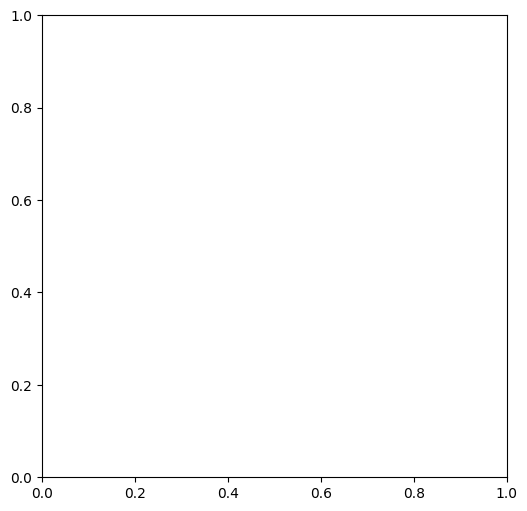

In [15]:
crossentropy = nn.CrossEntropyLoss(reduction='none')

def c_loss(logits, t_logits):
    prob2, pseudo_label2 = logits.softmax(dim=1).max(dim=1)
    prob, pseudo_label = t_logits.softmax(dim=1).max(dim=1)
    flag = prob > 0.95
    return (flag * crossentropy(logits, pseudo_label)).sum() / (flag.sum() + 1e-8), flag.sum(), torch.sum((pseudo_label==pseudo_label2) & flag).item()/(flag.sum().item() + 1e-8)

def save_model(epoch, feature_extractor, label_predictor):
    torch.save(feature_extractor.state_dict(), f'extractor_model_{epoch}.bin')
    torch.save(label_predictor.state_dict(), f'predictor_model_{epoch}.bin')

def train_model(epochs, gap, source_dataloader, target_dataloader, feature_extractor, label_predictor):
    print('Start training')
    marked_epoch = [0] + [gap*i - 1 for i in range(1, epochs//gap + 1)]
    for epoch in range(epochs):
        train_loss, train_acc, used_rate, pred_acc = train_epoch(source_dataloader, target_dataloader)
        if epoch in marked_epoch:
            save_model(epoch, feature_extractor, label_predictor)

        print(f'epoch {epoch:>3d}: train loss: {train_loss:6.4f}, acc: {train_acc:6.4f}, used rate {used_rate:6.4f},pred_acc {pred_acc:6.4f}')
    save_model('final', feature_extractor, label_predictor)

# Set your constants at the top of your script
EPOCHS = 500
GAP = 200
SOURCE_DATALOADER = source_dataloader  # define your source dataloader here
TARGET_DATALOADER = target_dataloader  # define your target dataloader here
FEATURE_EXTRACTOR = feature_extractor  # define your feature extractor here
LABEL_PREDICTOR = label_predictor    # define your label predictor here

# Then simply call the function to start training
train_model(EPOCHS, GAP, SOURCE_DATALOADER, TARGET_DATALOADER, FEATURE_EXTRACTOR, LABEL_PREDICTOR)

# Inference

We use pandas to generate our csv file.

BTW, the performance of the model trained for 200 epoches might be unstable. You can train for more epoches for a more stable performance.

In [ ]:
result = []
label_predictor.eval()
feature_extractor.eval()
with Progress(TextColumn("[progress.description]{task.description}"),
              BarColumn(),
              TextColumn("[progress.percentage]{task.percentage:>3.0f}%"),
              TimeRemainingColumn(),
              TimeElapsedColumn()) as progress:
    test_tqdm = progress.add_task(description="inference progress", total=len(test_dataloader))
    for i, (test_data, _) in (enumerate(test_dataloader)):
        test_data = test_data.cuda()

        class_logits = label_predictor(feature_extractor(test_data))

        x = torch.argmax(class_logits, dim=1).cpu().detach().numpy()
        result.append(x)
        progress.advance(test_tqdm)

import pandas as pd
result = np.concatenate(result)
# Generate your submission
df = pd.DataFrame({'id': np.arange(0,len(result)), 'label': result})
df.to_csv('./DaNN_submission2.csv',index=False)